# Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors as mcolors
from datetime import date
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

In [ ]:
f = pd.read_csv('/content/drive/MyDrive/Trips_2018.csv', index_col=0)

## Data Preprocessing
The data includes trip durations, start and end stations with corresponding geographical coordinates and timestamps. Other information includes bike ID, user type, birthyear, and gender.

In [ ]:
f.head()

tripduration                 starttime                  stoptime  \
0           970  2018-01-01 13:50:57.4340  2018-01-01 14:07:08.1860   
1           723  2018-01-01 15:33:30.1820  2018-01-01 15:45:33.3410   
2           496  2018-01-01 15:39:18.3370  2018-01-01 15:47:35.1720   
3           306  2018-01-01 15:40:13.3720  2018-01-01 15:45:20.1910   
4           306  2018-01-01 18:14:51.5680  2018-01-01 18:19:57.6420   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0           505.0             40.749013             -73.988484   31956   
1          3255.0             40.750585             -73.994685   32536   
2           525.0             40.755942             -74.002116   16069   
3           447.0             40.763707             -73.985162   31781   
4          3356.0             40.774667             -73.984706   30319   

     usertype  birth_year  gender  
0  Subscriber        1992       1  
1  Subscriber        1969       1  
2  Subscriber        1956       1  
3  Subscriber        1974       1  
4  Subscriber        1992       1

In [ ]:
f.describe()

tripduration  start_station_id  start_station_latitude  \
count  1.754834e+07      1.754584e+07            1.754834e+07   
mean   9.887432e+02      1.589282e+03            4.073737e+01   
std    1.889584e+04      1.439432e+03            3.225813e-02   
min    6.100000e+01      7.200000e+01            4.064654e+01   
25%    3.580000e+02      3.800000e+02            4.071755e+01   
50%    6.050000e+02      5.050000e+02            4.073818e+01   
75%    1.060000e+03      3.249000e+03            4.075763e+01   
max    1.951005e+07      3.721000e+03            4.550636e+01   

       start_station_longitude  end_station_id  end_station_latitude  \
count             1.754834e+07    1.754584e+07          1.754834e+07   
mean             -7.398260e+01    1.580830e+03          4.073704e+01   
std               1.912753e-02    1.438502e+03          3.206583e-02   
min              -7.402535e+01    7.200000e+01          4.064654e+01   
25%              -7.399521e+01    3.800000e+02          4.071755e+01   
50%              -7.398565e+01    5.050000e+02          4.073756e+01   
75%              -7.397283e+01    3.249000e+03          4.075725e+01   
max              -7.356891e+01    3.721000e+03          4.550636e+01   

       end_station_longitude        bikeid    birth_year        gender  
count           1.754834e+07  1.754834e+07  1.754834e+07  1.754834e+07  
mean           -7.398281e+01  2.656141e+04  1.978993e+03  1.148613e+00  
std             1.919611e-02  6.222916e+03  1.192922e+01  5.438043e-01  
min            -7.408364e+01  1.452900e+04  1.885000e+03  0.000000e+00  
25%            -7.399595e+01  2.029300e+04  1.969000e+03  1.000000e+00  
50%            -7.398602e+01  2.827000e+04  1.981000e+03  1.000000e+00  
75%            -7.397344e+01  3.185200e+04  1.989000e+03  1.000000e+00  
max            -7.356891e+01  3.583100e+04  2.002000e+03  2.000000e+00

The data contains unrealistic entries. This includes a trip duration of over 5000 hours and a birthyear before 1900. However, a trip cannot be discounted for an erroneous birthyear alone, as it could be a typo. Furthermore, the trip duration and birthyear are irrelevant to the clustering of stations, assuming the start and end station IDs are correct.

For the prediction models, unrealistic trip durations are unaccepted. Therefore, the top 2 %-longest trips are removed later.

The types of each variable are checked. `usertype` is converted to a binary variable and time features are converted to datetime format.

Standardization may be relevant, but it will be assessed later when choosing features.

In [ ]:
f.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object

In [ ]:
# converts string to Timestamp
f['starttime'] = pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime'] = pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")

In [ ]:
print(f['usertype'].value_counts())
f['subscriber'] = (f['usertype']=='Subscriber').astype(bool)
# Subscriber is now a binary variable
# True: subscriber, False: customer

Subscriber    15614825
Customer       1933514
Name: usertype, dtype: int64


350527 entries have been removed from tripduration


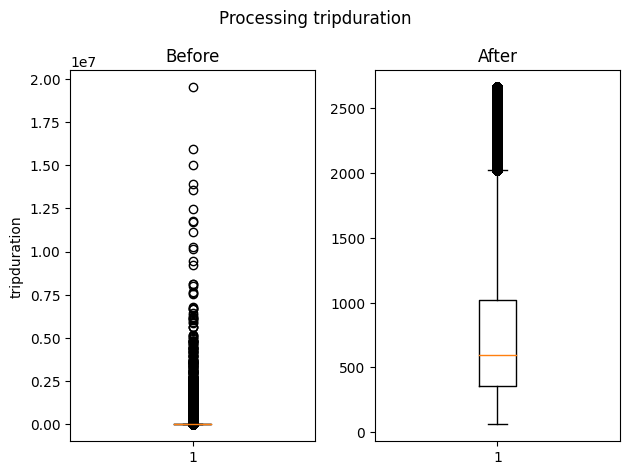

In [ ]:
duration = f['tripduration']
Q98 = np.percentile(duration, 98)

filtered_duration = duration[duration <= Q98]
print(f"{len(duration)-len(filtered_duration)} entries have been removed from tripduration")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Processing tripduration')
ax1.boxplot(duration)
ax1.set_ylabel("tripduration")
ax1.set_title("Before")
ax2.boxplot(filtered_duration)
ax2.set_title("After")
plt.tight_layout()
plt.show()

The figures above show the distributions before and after removing the 2 %-longest trips.

In [ ]:
# Remove the upper 2% quantile
f = f[(f['tripduration'] <= Q98)]

In [ ]:
nan_values = f.isnull().sum()
print(nan_values)

tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2161
start_station_latitude        0
start_station_longitude       0
end_station_id             2161
end_station_latitude          0
end_station_longitude         0
bikeid                        0
usertype                      0
birth_year                    0
gender                        0
subscriber                    0
dtype: int64


The NaN values in station IDs are removed.

In [ ]:
f = f.dropna()

The geographical data for the start stations are visualized.

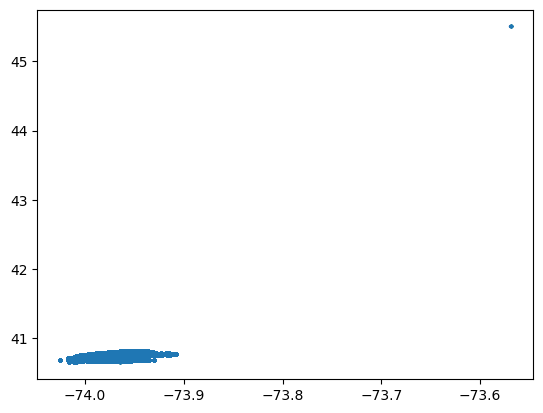

In [ ]:
# Pick relevant columns for clustering data
start_stations = f[['start_station_id','start_station_latitude',
                    'start_station_longitude']]

plt.scatter(start_stations['start_station_longitude'],
            start_stations['start_station_latitude'],s=2,alpha=0.5)
plt.show()

Outlying stations are observed in the north-eastern corner of the plot. The coordinates correspond to the city of Montreal, Canada. As the target area is New York City, these outliers are removed.

In [ ]:
# Remove the outliers from Montreal
f = f[
    (f['start_station_latitude'] <= 42) |
    (f['start_station_longitude'] <= -73.8)
]

Unique station IDs are extracted for use in the clustering of stations in the variable `start_stations` and illustrated on a map.

In [ ]:
# Drop duplicate stations based on start_station_id
start_stations = f[['start_station_id','start_station_latitude','start_station_longitude']]
start_stations = start_stations.drop_duplicates('start_station_id')
start_stations = start_stations.dropna()

print(f'start_stations has {len(start_stations)} rows')

start_stations has 816 rows


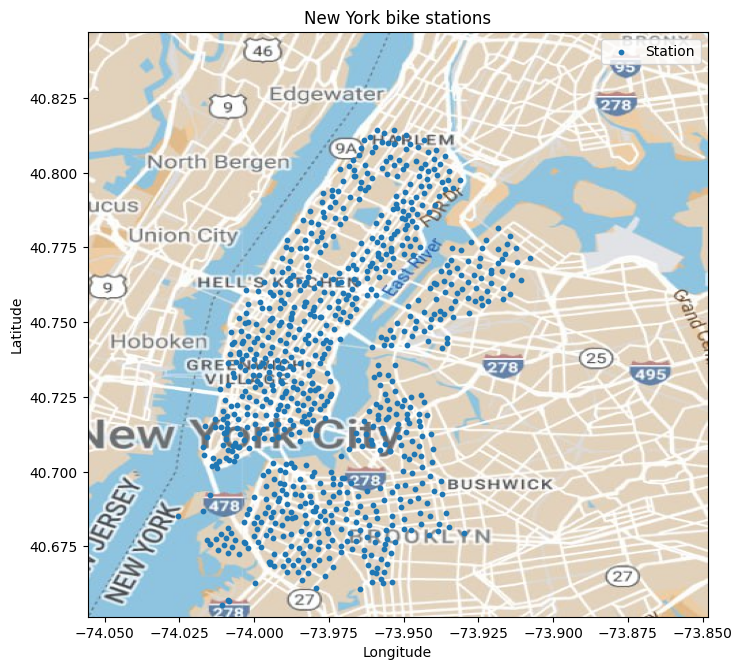

In [ ]:
coordinates = start_stations[['start_station_longitude','start_station_latitude']]

# Position map image correctly on axis
x_min = -74.05573
x_max = -73.84837
y_min = 40.65148
y_max = 40.84707

# Load the map image
background_img = mpimg.imread('/content/drive/MyDrive/NYC_map_large.jpg')

# Create figure with axis fitted to map image
fig, ax = plt.subplots(figsize=(8, 50))

# Insert the map image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max])

# Force axis to map image extents
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Scatter plot of stations
sc = ax.scatter(coordinates['start_station_longitude'],
                coordinates['start_station_latitude'], marker='o',
                s=10, label='Station')

# Insert labels, title, and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('New York bike stations')
ax.legend()

plt.show()

## Data Visualisation

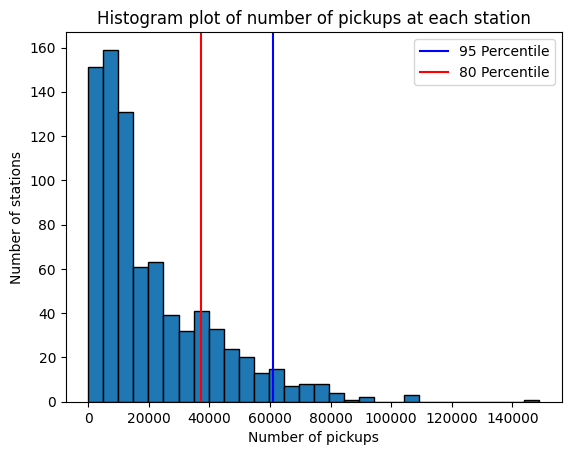

In [ ]:
## Histogram of the total number of pickups at each station

# Create count series
station_count_series = f['start_station_id'].value_counts()
start_stations['station_count'] = start_stations['start_station_id'].map(station_count_series)

# Plot upper and lower quartile
Q95 = np.percentile(station_count_series, 95)
Q80 = np.percentile(station_count_series, 80)
plt.axvline(x=Q95, color='b', label='95 Percentile')
plt.axvline(x=Q80, color='r', label='80 Percentile')

# Plot histogram
plt.hist(start_stations['station_count'], bins=30, edgecolor='k')
plt.title('Histogram plot of number of pickups at each station')
plt.ylabel('Number of stations')
plt.xlabel('Number of pickups')
plt.legend()
plt.show()

80% of the stations have a yearly pickup-rate of 37232 and below, while less than 5% have more than 61080.

A heatmap is created visualizing the demand.


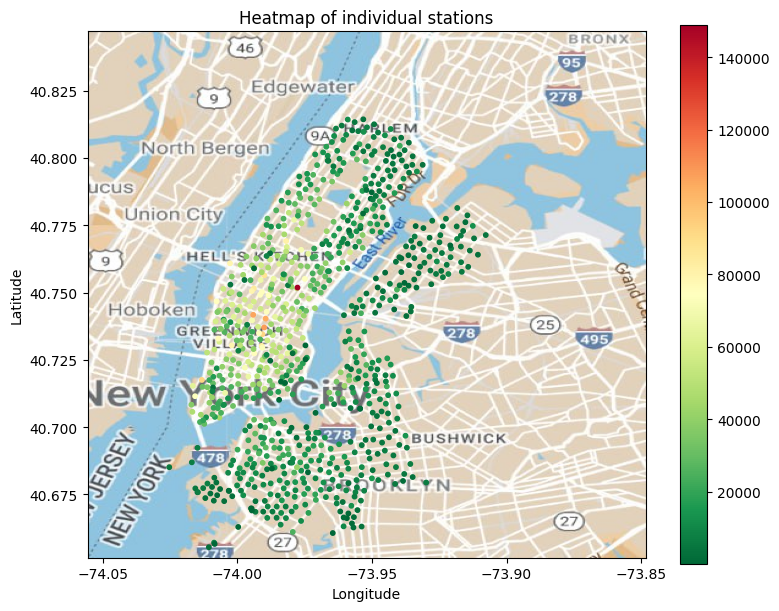

In [ ]:
# Create figure with axis fitted to map image
fig, ax = plt.subplots(figsize=(9,7))

# Insert the map image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max])

# Force axis to map image extents
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Heatmap scatter plot based on the count for each cluster
x = start_stations['start_station_longitude']
y = start_stations['start_station_latitude']
colors = start_stations['station_count']
hm = ax.scatter(x, y, c=colors, cmap='RdYlGn_r', s=10)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.locator_params(axis='x', nbins=5)
fig.colorbar(hm, ax=ax)
plt.title('Heatmap of individual stations')
plt.show()

The area between Greenwich Village and Central Park is where the demand is largest as indicated in the figure.

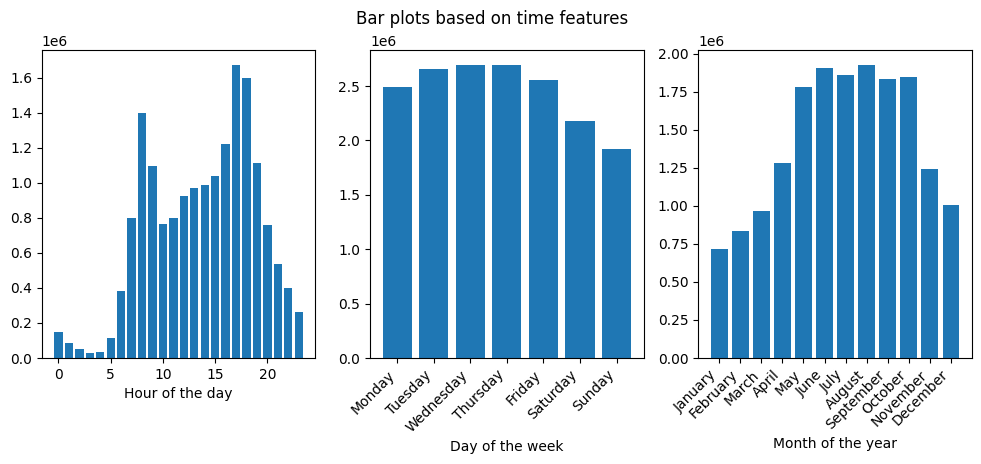

In [ ]:
## Plot of time dependency

# Add time features to dataframe
f['hour'] = f['starttime'].dt.hour
f['day'] = f['starttime'].dt.day_name()
f['month'] = f['starttime'].dt.month_name()

# Count entries based on time
hour_count = f.groupby('hour').size()
month_count = f.groupby('month').size()
week_count = f.groupby('day').size()

# Re-order axes to be more intuitive
ordered_days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                'Saturday', 'Sunday']
ordered_mths = ["January", "February", "March", "April", "May", "June", "July",
                "August", "September", "October", "November", "December"]
week_count = week_count.reindex(ordered_days)
month_count = month_count.reindex(ordered_mths)

# Plot bar plots based on time features
plt.rcParams['figure.figsize'] = [12, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.bar(hour_count.index, hour_count)
ax1.set_xlabel('Hour of the day')
ax2.bar(week_count.index, week_count)
ax2.set_xlabel('Day of the week')
ax2.set_xticks(ordered_days)
ax2.set_xticklabels(ordered_days, rotation=45, ha='right')
ax3.bar(month_count.index, month_count)
ax3.set_xlabel('Month of the year')
ax3.set_xticks(ordered_mths)
ax3.set_xticklabels(ordered_mths, rotation=45, ha='right')

plt.suptitle("Bar plots based on time features")
plt.show()
plt.rcParams['figure.figsize'] = [6.4, 4.8] # revert to default size

Higher demand occurs between 8-10 AM and 5-7 PM. Furthermore, bikes are mostly used during the summer months and weekdays.

To save memory, unused features for the prediction are removed. Since geographical data is saved in `coordinates`, these are removed too. From previous tests, using only lagged features performed better than including other features. Therefore, `tripduration`, `bikeid`, `usertype`, `gender`, `birth_year`, and `subscriber` are removed. Since lagged features contain similar data, standardization is unnecessary.

In [ ]:
# Dataframe before dropping columns to reduce memory usage
f.head()

tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0           505.0             40.749013             -73.988484   31956   
1          3255.0             40.750585             -73.994685   32536   
2           525.0             40.755942             -74.002116   16069   
3           447.0             40.763707             -73.985162   31781   
4          3356.0             40.774667             -73.984706   30319   

     usertype  birth_year  gender  subscriber  
0  Subscriber        1992       1        True  
1  Subscriber        1969       1        True  
2  Subscriber        1956       1        True  
3  Subscriber        1974       1        True  
4  Subscriber        1992       1        True

In [ ]:
# Drop features that are not used in the prediction challenge
f = f.drop(['tripduration','bikeid','usertype','gender','birth_year','subscriber'], axis=1)
f = f.drop(['hour','day','month'], axis=1)
f = f.drop(['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude'], axis=1)
f.head()

starttime                stoptime  start_station_id  \
0 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186              72.0   
1 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341              72.0   
2 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172              72.0   
3 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191              72.0   
4 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642              72.0   

   end_station_id  
0           505.0  
1          3255.0  
2           525.0  
3           447.0  
4          3356.0

## Clustering
Stations are clustered spatially using geographical data to represent areas of interest.

### K-Means
The elbow-method is used to estimate the number of clusters needed.

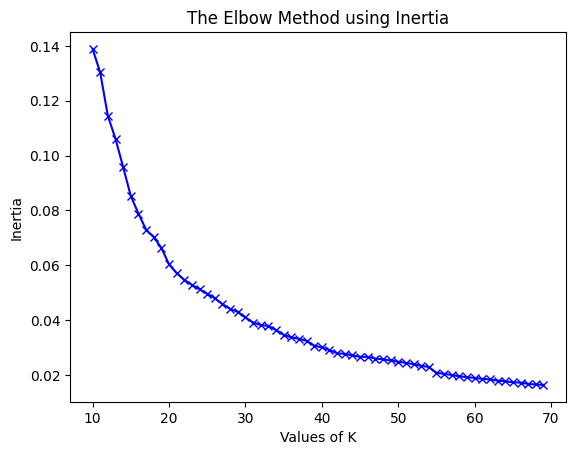

In [ ]:
inertias = []
K = range(10, 70)

for k in K:
    # Building and fitting the model
    KM = KMeans(n_clusters=k, n_init='auto', random_state=10)
    KM.fit(coordinates)
    inertias.append(KM.inertia_)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

40 clusters are judged to be appropriate and illustrated below.

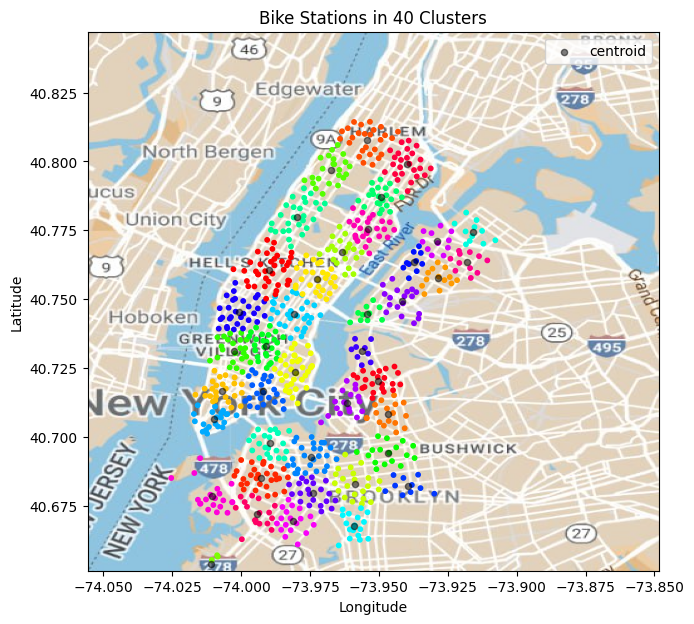

In [ ]:
# K-means algorithm ran for 40 clusters
K = 40
KM = KMeans(n_clusters=K, n_init='auto', random_state=10)
KM.fit(coordinates)

# Generate colours for plotting
cluster_colors = plt.cm.get_cmap('hsv', K)

# Plot clusters
# Create figure with axis fitted to map image
fig, ax = plt.subplots(figsize=(9,7))

# Insert the map image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max])

# Force axis to map image extents
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot individual stations with cluster color
x_ = []
y_ = []
c_ = []
for label, x, y in zip(KM.labels_, coordinates['start_station_longitude'],
                       coordinates['start_station_latitude']):
    if label == -1:
        continue
    x_.append(x)
    y_.append(y)
    c_.append(cluster_colors(label))
sc1 = ax.scatter(x_, y_, s=10, c=c_)

# Plot cluster centroids
sc2 = ax.scatter(KM.cluster_centers_[:,0], KM.cluster_centers_[:,1], s=20, c='k',
             alpha=0.5, edgecolor='k', label='centroid')

# Insert labels, title, and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Bike Stations in {K} Clusters')
ax.legend()
plt.show()

### DBSCAN
The DBSCAN-algorithm is calibrated across iterations.

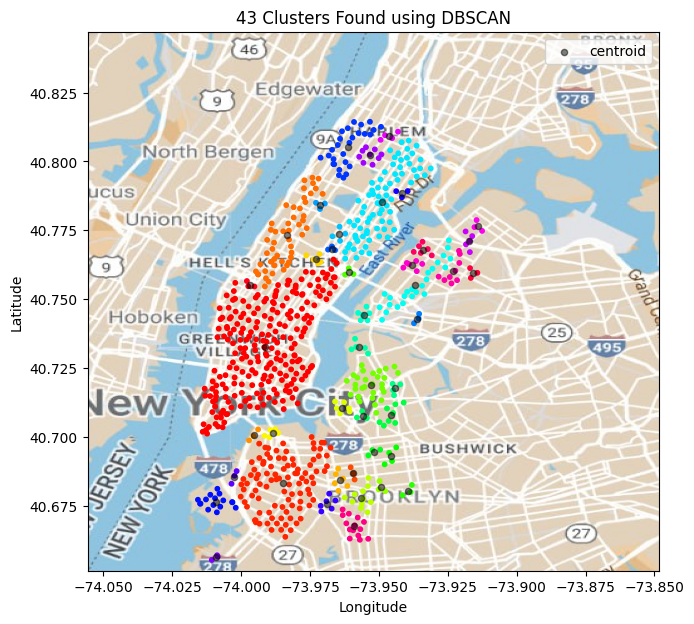

In [ ]:
dbs = DBSCAN(min_samples = 3, eps = 0.0033)
# min_sample: MinPts
# eps: radius of reachability

dbs.fit(coordinates)

# Generate colours for plotting
num_colors = len(set(dbs.labels_))
# Omit label color for outliers
if np.unique(dbs.labels_)[0] == -1:
    num_colors -= 1
cluster_colors = plt.cm.get_cmap('hsv', num_colors)

# Plot clusters
# Create figure with axis fitted to map image
fig, ax = plt.subplots(figsize=(9,7))

# Insert the map image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max])

# Force axis to map image extents
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot individual stations with cluster color
x_ = []
y_ = []
c_ = []
for label, x, y in zip(dbs.labels_, coordinates['start_station_longitude'],
                       coordinates['start_station_latitude']):
    if label == -1:
        continue
    x_.append(x)
    y_.append(y)
    c_.append(cluster_colors(label))
plt.scatter(x_, y_, s=10, c=c_)

# Compute cluster centroids for visualisation
centroids = []
for i in range(len(set(dbs.labels_))):
    cluster_idx = np.argwhere(dbs.labels_ == i)
    cluster_x = coordinates['start_station_longitude'].values[cluster_idx]
    cluster_y = coordinates['start_station_latitude'].values[cluster_idx]
    cluster_pts = np.concatenate((cluster_x,cluster_y),axis=1)
    cluster_centroid = np.mean(cluster_pts, axis=0)
    centroids.append(cluster_centroid)
centroids = np.array(centroids)

# Plot cluster centroids
plt.scatter(centroids[:,0], centroids[:,1], s=20, c='k',
             alpha=0.5, edgecolor='k', label='centroid')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{num_colors} Clusters Found using DBSCAN')
plt.legend()
plt.show()

### Choice of Algorithm
The goal is to cluster nearby stations. DBSCAN allows for arbitrary shapes and not all stations are assigned to a cluster as outliers are allowed. For K-means, all stations are assigned a cluster and clusters created are more spherical. The spherical shape ensures that stations on average will be closer within a cluster. This is supported by the higher mean silhouette score from the KMeans clustering.

Therefore, K-means is chosen.

In [ ]:
KM_ss = silhouette_score(coordinates, KM.labels_)
dbs_ss = silhouette_score(coordinates, dbs.labels_)
print(f"Silhouette Scores: \n K-Means: {KM_ss} \t DBSCAN: {dbs_ss}")

Silhouette Scores: 
 K-Means: 0.34957273871775313 	 DBSCAN: -0.1575379920366832


In [ ]:
# Create a dictionary matching the start_station_id and clusters found
keys = start_stations['start_station_id'].to_list()
values = KM.labels_
clusters_dict = {keys[i]: values[i] for i in range(len(keys))}

# Prediction Challenge
The data is aggregated into hourly pickups. The analysis is conducted on the cluster with the largest demand. The goal is to predict the pickups 24 hours later.

In [ ]:
# Add new column for cluster id
f['start_cluster_id'] = f['start_station_id'].map(clusters_dict)
f['end_cluster_id'] = f['end_station_id'].map(clusters_dict)

# Count the number of entries for each cluster and station
cluster_count_series = f['start_cluster_id'].value_counts()

# Print the top 3 clusters
for i in range(3):
  id =  cluster_count_series.index[i]
  print(f"Cluster {id} : {cluster_count_series[id]} pickups")

max_cluster = cluster_count_series.index[0]
f_cluster = f.loc[f['start_cluster_id']==max_cluster]

f_cluster.set_index('starttime', inplace=True)
f_cluster.loc[:,('pickups')] = 1

print(f"\nCluster {max_cluster} has the largest total number of pickups and it is used for analysis.")

Cluster 27 : 1515362 pickups
Cluster 0 : 1508091 pickups
Cluster 21 : 1357698 pickups

Cluster 27 has the largest total number of pickups and it is used for analysis.


In [ ]:
# Add cluster features to dataframe
start_stations['start_cluster_id'] = start_stations['start_station_id'].map(clusters_dict)
start_stations['cluster_count'] = start_stations['start_cluster_id'].map(cluster_count_series)
start_stations.head()

start_station_id  start_station_latitude  start_station_longitude  \
0                 72.0               40.767272               -73.993929   
1324              79.0               40.719116               -74.006667   
2430              82.0               40.711174               -74.000165   
2866              83.0               40.683826               -73.976323   
3551             119.0               40.696089               -73.978034   

      station_count  start_cluster_id  cluster_count  
0             37674                 0        1508091  
1324          26680                 5         800829  
2430          10073                 5         800829  
2866          12848                29         294980  
3551           3187                23         325705

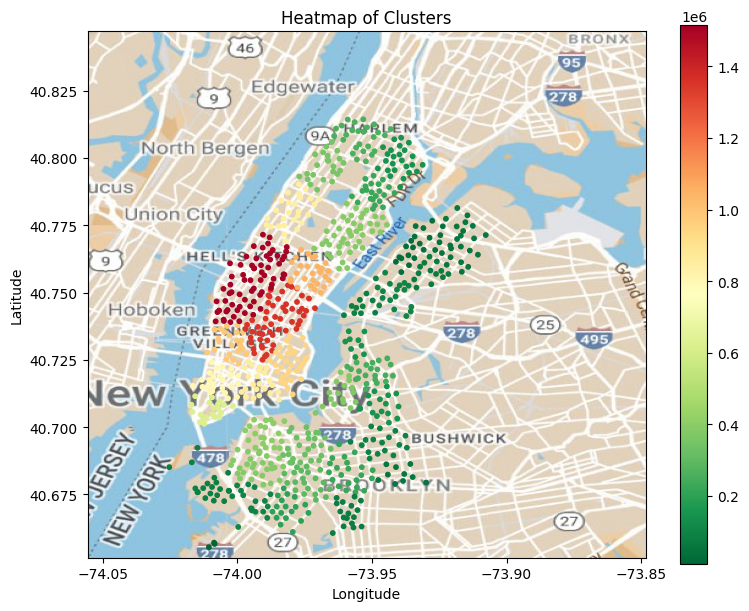

In [ ]:
# Heatmap scatter plot based on the count for each cluster
x = start_stations['start_station_longitude']
y = start_stations['start_station_latitude']
colors = start_stations['cluster_count']

# Create figure with axis fitted to map image
fig, ax = plt.subplots(figsize=(9,7))

# Insert the map image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max])
hm = ax.scatter(x, y, c=colors, cmap='RdYlGn_r', s=10)

# Force axis to map image extents
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heatmap of Clusters')
ax.locator_params(axis='x', nbins=5)
fig.colorbar(hm, ax=ax)
fig.show()


The heatmap for clusters confirms the heatmap for individual stations.

In [ ]:
# Training set: January to October
# Test set: November to December.
split_date = date(2018, 11, 1)

## Bike Pickups
To model the demand at the start stations, three different models are assessed.

For each model, different feature combinations are tested. Each iteration uses the features from previous iterations, i.e., the first iteration only uses the data from 24 hours prior. The next iteration from 24 and 48 hours prior and so on.

In [ ]:
# Aggregate hourly, and sum the pickups
f_agg = f_cluster.resample("1H").agg({'pickups':'sum'})
f_agg.head()

pickups
starttime                   
2018-01-01 00:00:00        9
2018-01-01 01:00:00       13
2018-01-01 02:00:00        8
2018-01-01 03:00:00       10
2018-01-01 04:00:00        5

In [ ]:
def buildLaggedFeatures(s,columns, lag=1,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            new_dict['%s_lag%d' %(col_name,lag)]=s[col_name].shift(lag)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [ ]:
import csv
out_file = open('Project_output.csv','w')
writer = csv.writer(out_file)
header = [['Target Variable', 'Model','No. of lags days', 'No. of clusters',
           'R2', 'Mse', 'RMSE', 'MAE']]
writer.writerows(header)
out_file.close()

def write_to_output(target_var, model_name, n_days, n_clusters, metrics):
    """
    Utility function to save metrics into CSV for further analysis.
    """
    with open('Project_output.csv','a') as file:
      writer = csv.writer(file)
      row = [[target_var, model_name, n_days, n_clusters,
              metrics[0],metrics[1],metrics[2],metrics[3]]]
      writer.writerows(row)

### Baseline
For comparison, a baseline model (BL) is created. The model uses the average of the *x* number of days prior.

The function below does the train/test data split and model training. It returns the test metrics, predicted values, and real values.

In [ ]:
def fit_baseline(f: pd.DataFrame, target:str, verbose=True):
    """
    Fits a baseline model that uses the average of the training dataset.

    Parameters
    --------------------
      f : pd.DataFrame
        Pandas dataframe to split into training and test sets.
      target : str
        Key name of target variable in f.

    Returns
    -------------------
    metrics : list
      [r2, mse, rmse, mae]
    predictions : array
    y_test : array
    """
    # Split dataset into training and test sets
    train = f[:split_date]
    test = f[split_date:]

    # Split features for training and test
    X_train = train.drop([target], axis=1)
    y_train = train[[target]]
    X_test = test.drop([target], axis=1)
    y_test = test[[target]]

    # Train model
    predictions = X_test.mean(axis=1)

    # Evaluate scores
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mae = mean_absolute_error(y_test, predictions)
    metrics = [r2, mse, rmse, mae]

    if verbose==True:
        print(f"\t Size of training set: {len(X_train)}")
        print(f"\t R^2 Score: {r2}")
        print(f"\t RMSE Score: {rmse}")
        print(f"\t MAE Score: {mae}")
    return metrics, predictions, y_test

The script below loops through the different combinations of days.

In [ ]:
# Add lagged features to model
f_lagged = f_agg
r2_scores = []
rmse_scores = []
mae_scores = []
for i in range(1,11):
    print(f"Lag by {i} days")
    f_lagged = buildLaggedFeatures(f_lagged, ['pickups'], lag=24*i)

    # Train and evaluate model
    metrics, _, _ = fit_baseline(f_lagged, 'pickups')
    r2_scores.append(metrics[0])
    rmse_scores.append(metrics[2])
    mae_scores.append(metrics[3])

# Find max score based on the R2 score
max_score = max(r2_scores)
max_index = r2_scores.index(max_score)
print("-------------------------")
print("Best performing model")
print(f"\t R^2 Score: {max_score}")
print(f"\t RMSE Score: {rmse_scores[max_index]}")
print(f"\t MAE Score: {mae_scores[max_index]}")
print(f"\t uses lagged features up till {max_index+1} days")

write_to_output('Pickups','Baseline',max_index+1,K,
                [max(r2_scores),'NIL',rmse_scores[max_index],mae_scores[max_index]])

Lag by 1 days
	 Size of training set: 7273
	 R^2 Score: 0.483123224818213
	 RMSE Score: 95.5388406982585
	 MAE Score: 55.23838797814208
Lag by 2 days
	 Size of training set: 7225
	 R^2 Score: 0.4560682565820058
	 RMSE Score: 98.00735307532084
	 MAE Score: 59.39549180327869
Lag by 3 days
	 Size of training set: 7153
	 R^2 Score: 0.43157031300550763
	 RMSE Score: 100.1901054259254
	 MAE Score: 62.69353369763206
Lag by 4 days
	 Size of training set: 7057
	 R^2 Score: 0.4288668242627143
	 RMSE Score: 100.42807815292032
	 MAE Score: 64.65898224043715
Lag by 5 days
	 Size of training set: 6937
	 R^2 Score: 0.4457680588430053
	 RMSE Score: 98.93096229465499
	 MAE Score: 64.08032786885246
Lag by 6 days
	 Size of training set: 6793
	 R^2 Score: 0.5088693653065269
	 RMSE Score: 93.12900653761133
	 MAE Score: 60.446607468123865
Lag by 7 days
	 Size of training set: 6625
	 R^2 Score: 0.5688776550930399
	 RMSE Score: 87.25427699940798
	 MAE Score: 56.64968774395005
Lag by 8 days
	 Size of training 

The best performing baseline model uses 8 days of lagged features based on the metrics.

### Linear Regression
Like the baseline model, a function creating and evaluating a linear regression (LR) model is set up.

In [ ]:
def fit_linear_reg(f: pd.DataFrame, target: str, verbose=True):
    """
    Fits a linear regression model using the specified target variable.

    Parameters
    --------------------
      f : pd.DataFrame
        Pandas dataframe to split into training and test sets.
      target : str
        Key name of target variable in f.

    Returns
    -------------------
    metrics : list
      [r2, mse, rmse, mae]
    predictions : array
    y_test : array
    """

    # Split dataset into training and test sets
    train = f[:split_date]
    test = f[split_date:]

    # Split features for training and test
    X_train = train.drop([target], axis=1)
    y_train = train[[target]]
    X_test = test.drop([target], axis=1)
    y_test = test[[target]]

    # Train model
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X_train, y_train)
    predictions = regr.predict(X_test)

    # Evaluate scores
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mae = mean_absolute_error(y_test, predictions)
    metrics = [r2, mse, rmse, mae]

    if verbose==True:
      print(f"\t Size of training set: {len(X_train)}")
      print(f"\t R^2 Score: {r2}")
      print(f"\t RMSE Score: {rmse}")
      print(f"\t MAE Score: {mae}")

    return metrics, predictions, y_test

In [ ]:
def plot_metrics(r2_scores, rmse_scores, mae_scores, title):
    """
    Plots 3 subfigures of the R2, RMSE, and MAE scores against no. of lagged days.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
    # Plot R2 scores
    ax1.plot(range(1,11),r2_scores,c='r')
    ax1.set_title('$R^2$ Scores')
    ax1.set_xlabel('No. of days lagged')
    ax1.plot(max_index+1, r2_scores[max_index], marker='o', c='r', label='best')
    ax1.legend()
    # Plot RMSE scores
    ax2.plot(range(1,11),rmse_scores,c='b')
    ax2.set_title('RMSE Scores')
    ax2.set_xlabel('No. of days lagged')
    ax2.plot(max_index+1, rmse_scores[max_index], marker='o', c='b', label='best')
    ax2.legend()
    # Plot MAE scores
    ax3.plot(range(1,11), mae_scores,c='g')
    ax3.set_title('MAE Scores')
    ax3.set_xlabel('No. of days lagged')
    ax3.plot(max_index+1, mae_scores[max_index], marker='o', c='g', label='best')
    ax3.legend()
    plt.suptitle(title)
    plt.show()

In [ ]:
f_lagged = f_agg
r2_scores = []
rmse_scores = []
mae_scores = []

# Add lagged features to model
for i in range(1,11):
    print(f"Lag by {i} days")
    f_lagged = buildLaggedFeatures(f_lagged, ['pickups'], lag=24*i)

    # Train and evaluate model
    metrics, _, _ = fit_linear_reg(f_lagged, 'pickups')
    r2_scores.append(metrics[0])
    rmse_scores.append(metrics[2])
    mae_scores.append(metrics[3])

# Find max score
max_score = max(r2_scores)
max_index = r2_scores.index(max_score)
print("-------------------------")
print("Best performing model (based on R^2 score)")
print(f"\t R^2 Score: {max_score}")
print(f"\t RMSE Score: {rmse_scores[max_index]}")
print(f"\t MAE Score: {mae_scores[max_index]}")
print(f"\t uses lagged features up till {max_index+1} days")

write_to_output('Pickups','Linear Regression',max_index+1,K,
                [max(r2_scores),'NIL',rmse_scores[max_index],mae_scores[max_index]])

Lag by 1 days
	 Size of training set: 7273
	 R^2 Score: 0.5207836540219896
	 RMSE Score: 91.99246781946688
	 MAE Score: 53.40695171318829
Lag by 2 days
	 Size of training set: 7225
	 R^2 Score: 0.5312234963696688
	 RMSE Score: 90.98491121604381
	 MAE Score: 53.32419612583133
Lag by 3 days
	 Size of training set: 7153
	 R^2 Score: 0.539672632884735
	 RMSE Score: 90.1612357276517
	 MAE Score: 55.464641360484336
Lag by 4 days
	 Size of training set: 7057
	 R^2 Score: 0.555259375502773
	 RMSE Score: 88.62165550531553
	 MAE Score: 55.23052044421008
Lag by 5 days
	 Size of training set: 6937
	 R^2 Score: 0.5725351459679839
	 RMSE Score: 86.88337131275273
	 MAE Score: 55.42448514724532
Lag by 6 days
	 Size of training set: 6793
	 R^2 Score: 0.650537570173179
	 RMSE Score: 78.55732814253423
	 MAE Score: 50.10428459513684
Lag by 7 days
	 Size of training set: 6625
	 R^2 Score: 0.6553264964750906
	 RMSE Score: 78.01720854661313
	 MAE Score: 47.47931078793581
Lag by 8 days
	 Size of training set:

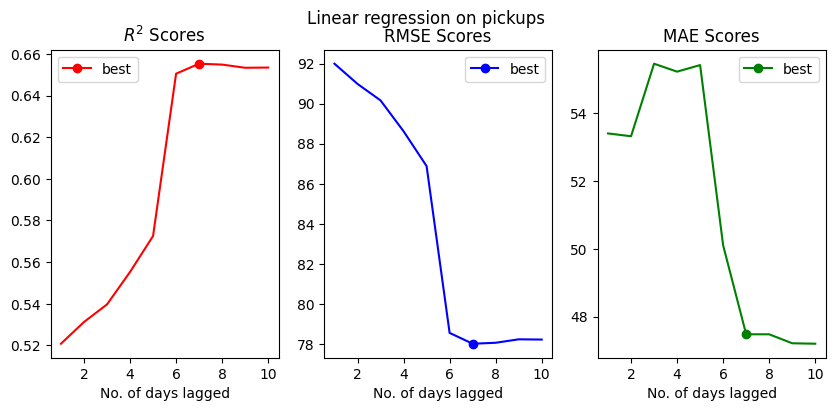

In [ ]:
plot_metrics(r2_scores, rmse_scores, mae_scores, "Linear regression on pickups")

The figures above indicate that the model using 7 days of lagged features performs the best.

	 Size of training set: 6625
	 R^2 Score: 0.6553264964750906
	 RMSE Score: 78.01720854661313
	 MAE Score: 47.47931078793581


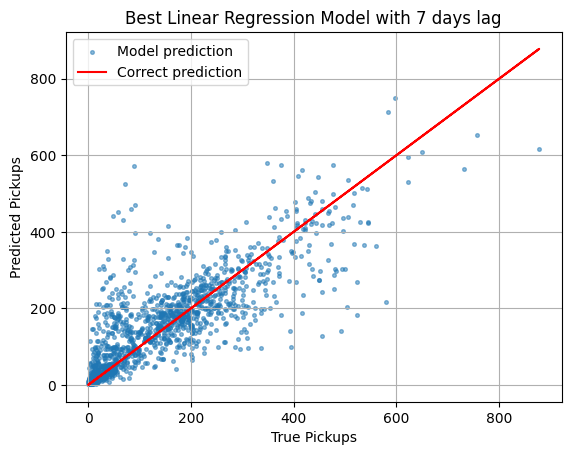

In [ ]:
# Add lagged features to model
f_lagged = f_agg
n_days = max_index+1
for i in range(1,n_days+1):
    f_lagged = buildLaggedFeatures(f_lagged, ['pickups'], lag=24*i)

_, predictions, y_test = fit_linear_reg(f_lagged,'pickups')

# Plot predictions and test value
plt.scatter(y_test, predictions, s=7, alpha=0.5, label='Model prediction')
plt.plot(y_test, y_test, c='r', label='Correct prediction')
plt.xlabel('True Pickups')
plt.ylabel('Predicted Pickups')
plt.title(f'Best Linear Regression Model with {n_days} days lag')
plt.grid()
plt.legend()
plt.show()

The figure above indicates no clear tendency of whether the model tends to under- or overestimate.

### Gradient Boosting Regressor
Similarly, a function building a gradient boosting regressor (GBR) is made.

In [ ]:
def fit_gbr(f: pd.DataFrame, target: str, verbose=True):
    """
    Fits a Gradient Boosting Regressor model using the specified target variable.

    Parameters
      f : pd.DataFrame
        Pandas dataframe to split into training and test sets.
      target : str
        Key name of target variable in f.

    Returns
    -------------------
    metrics : list
      [r2, mse, rmse, mae]
    predictions : array
    y_test : array
    """
    # Add time features
    f_copy = f.copy()
    f_copy['time'] = f_copy.index
    f_copy['hour'] = f_copy['time'].dt.hour
    f_copy['day_of_week'] = f_copy['time'].dt.dayofweek
    f_copy['month'] = f_copy['time'].dt.month
    f_copy = f_copy.drop(['time'], axis=1)

    # Split dataset into training and test sets
    train = f_copy[:split_date]
    test = f_copy[split_date:]

    # Split features for training and test
    X_train = train.drop([target], axis=1)
    y_train = train[[target]]
    X_test = test.drop([target], axis=1)
    y_test = test[[target]]

    # Define hyperparameters
    learning_rate = 0.01  # Default is 0.1.
    n_estimators = 250
    max_depth = 10        # Default is 3. Values up to increase complexity.
    min_samples_split = 5 # Increasing this can sometimes help in generalization.
    min_samples_leaf = 2  # increasing might help in some cases.
    max_features = 'log2'   # 'sqrt' or 'log2'.

    model = GradientBoostingRegressor(learning_rate=learning_rate,
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  max_features=max_features,
                                  random_state=0)

    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)

    # Evaluate scores
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mae = mean_absolute_error(y_test, predictions)
    metrics = [r2, mse, rmse, mae]

    if verbose==True:
        print(f"\t Size of training set: {len(X_train)}")
        print(f"\t R^2 Score: {r2}")
        print(f"\t RMSE Score: {rmse}")
        print(f"\t MAE Score: {mae}")

    return metrics, predictions, y_test

In [ ]:
# Add lagged features to model
f_lagged = f_agg
r2_scores = []
rmse_scores = []
mae_scores = []
for i in range(1,11):
    print(f"Lag by {i} days")
    f_lagged = buildLaggedFeatures(f_lagged, ['pickups'], lag=24*i)

    # Train and evaluate model
    metrics, _, _ = fit_gbr(f_lagged, 'pickups')
    r2_scores.append(metrics[0])
    rmse_scores.append(metrics[2])
    mae_scores.append(metrics[3])

# Find max score
max_score = max(r2_scores)
max_index = r2_scores.index(max_score)
print("-------------------------")
print("Best performing model (based on R^2 score)")
print(f"\t R^2 Score: {max_score}")
print(f"\t RMSE Score: {rmse_scores[max_index]}")
print(f"\t MAE Score: {mae_scores[max_index]}")
print(f"\t uses lagged features up till {max_index+1} days")

write_to_output('Pickups','GBR',max_index+1,K,
                [max(r2_scores),'NIL',rmse_scores[max_index],mae_scores[max_index]])

Lag by 1 days
	 Size of training set: 7273
	 R^2 Score: 0.36713315009581826
	 RMSE Score: 105.71646478182575
	 MAE Score: 71.36249434594863
Lag by 2 days
	 Size of training set: 7225
	 R^2 Score: 0.5266040463561953
	 RMSE Score: 91.43210713845863
	 MAE Score: 61.42420700957731
Lag by 3 days
	 Size of training set: 7153
	 R^2 Score: 0.590746903737267
	 RMSE Score: 85.01243284299436
	 MAE Score: 56.73447765309514
Lag by 4 days
	 Size of training set: 7057
	 R^2 Score: 0.6338545755167418
	 RMSE Score: 80.41059275118191
	 MAE Score: 52.97399846951638
Lag by 5 days
	 Size of training set: 6937
	 R^2 Score: 0.6386035846161059
	 RMSE Score: 79.88741678161912
	 MAE Score: 52.24056642484581
Lag by 6 days
	 Size of training set: 6793
	 R^2 Score: 0.6781299081268313
	 RMSE Score: 75.39226133634064
	 MAE Score: 48.74767439230532
Lag by 7 days
	 Size of training set: 6625
	 R^2 Score: 0.6729432347145458
	 RMSE Score: 75.9972760777815
	 MAE Score: 47.964504203225644
Lag by 8 days
	 Size of training 

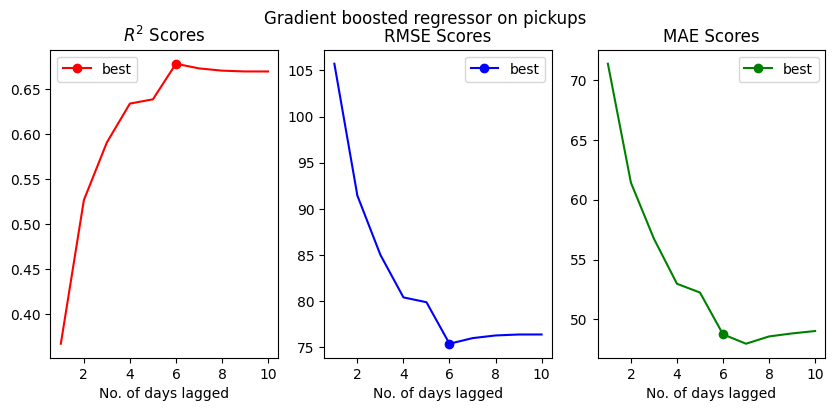

In [ ]:
plot_metrics(r2_scores, rmse_scores, mae_scores, "Gradient boosted regressor on pickups")

The figures above indicate the model using 6 days of lagged features performs best.

	 Size of training set: 6793
	 R^2 Score: 0.6781299081268313
	 RMSE Score: 75.39226133634064
	 MAE Score: 48.74767439230532


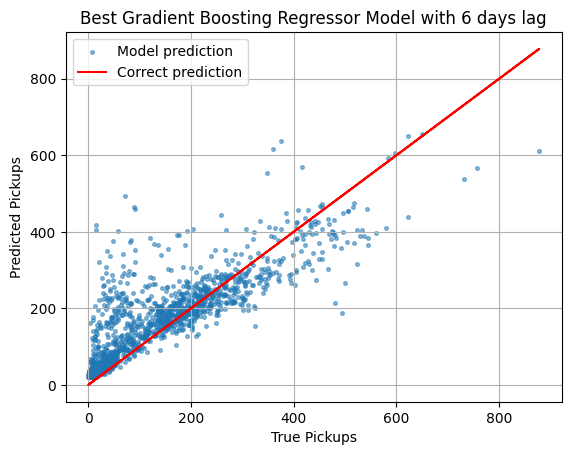

In [ ]:
# Add lagged features to model
f_lagged = f_agg
n_days = max_index+1
for i in range(1,n_days+1):
    f_lagged = buildLaggedFeatures(f_lagged, ['pickups'], lag=24*i)

_, predictions, y_test = fit_gbr(f_lagged, 'pickups')

# Plot predictions and test value
plt.scatter(y_test, predictions, s=7, alpha=0.5, label='Model prediction')
plt.plot(y_test, y_test, c='r', label='Correct prediction')
plt.xlabel('True Pickups')
plt.ylabel('Predicted Pickups')
plt.title(f'Best Gradient Boosting Regressor Model with {n_days} days lag')
plt.grid()
plt.legend()
plt.show()

The figure above indicates the GBR tends to overestimate the pickups for low values. This tendency shifts for higher values, first becoming more evenly spread before tending more towards underestimating. Underestimation of pickups can lead to bike shortages.

## Bike Dropoffs
The same approach is used to create models for the dropoffs.

In [ ]:
# Use entries with the max_cluster as the end cluster during dropoffs
f_cluster = f.loc[f['end_cluster_id']==max_cluster]
f_cluster.set_index('stoptime', inplace=True)
f_cluster.loc[:,('dropoffs')] = 1

# Aggregate hourly, and sum the dropoffs
f_agg = f_cluster.resample("1H").agg({'dropoffs':'sum'})
f_agg.head()

dropoffs
stoptime                     
2018-01-01 00:00:00        13
2018-01-01 01:00:00        15
2018-01-01 02:00:00         8
2018-01-01 03:00:00         9
2018-01-01 04:00:00         5

### Baseline

In [ ]:
# Add lagged features to model
f_lagged = f_agg
r2_scores = []
rmse_scores = []
mae_scores = []
for i in range(1,11):
    print(f"Lag by {i} days")
    f_lagged = buildLaggedFeatures(f_lagged, ['dropoffs'], lag=24*i)

    # Train and evaluate model
    metrics, _, _ = fit_baseline(f_lagged, 'dropoffs')
    r2_scores.append(metrics[0])
    rmse_scores.append(metrics[2])
    mae_scores.append(metrics[3])

# Find max score
max_score = max(r2_scores)
max_index = r2_scores.index(max_score)
print("-------------------------")
print("Best performing model (based on $R^2$ score)")
print(f"\t R^2 Score: {max_score}")
print(f"\t RMSE Score: {rmse_scores[max_index]}")
print(f"\t MAE Score: {mae_scores[max_index]}")
print(f"\t uses lagged features up till {max_index+1} days")

write_to_output('Dropoffs','Baseline',max_index+1,K,
                [max(r2_scores),'NIL',rmse_scores[max_index],mae_scores[max_index]])

Lag by 1 days
	 Size of training set: 7273
	 R^2 Score: 0.5042932857672839
	 RMSE Score: 98.67714100538477
	 MAE Score: 55.44846416382253
Lag by 2 days
	 Size of training set: 7225
	 R^2 Score: 0.4821047974429177
	 RMSE Score: 100.8614253969564
	 MAE Score: 59.465870307167236
Lag by 3 days
	 Size of training set: 7153
	 R^2 Score: 0.46056911956298674
	 RMSE Score: 102.93713100211104
	 MAE Score: 62.74357224118316
Lag by 4 days
	 Size of training set: 7057
	 R^2 Score: 0.4556536881675879
	 RMSE Score: 103.40506210336456
	 MAE Score: 64.73839590443686
Lag by 5 days
	 Size of training set: 6937
	 R^2 Score: 0.4685600835874576
	 RMSE Score: 102.17184667294474
	 MAE Score: 64.20150170648463
Lag by 6 days
	 Size of training set: 6793
	 R^2 Score: 0.5272914216338584
	 RMSE Score: 96.36091145258379
	 MAE Score: 60.6650739476678
Lag by 7 days
	 Size of training set: 6625
	 R^2 Score: 0.5868227347610244
	 RMSE Score: 90.0891243760814
	 MAE Score: 56.70180399804973
Lag by 8 days
	 Size of trainin

The best performing baseline model uses 8 days of lagged features based on the metrics.

### Linear Regression

In [ ]:
f_lagged = f_agg
r2_scores = []
rmse_scores = []
mae_scores = []

# Add lagged features to model
for i in range(1,11):
    print(f"Lag by {i} days")
    f_lagged = buildLaggedFeatures(f_lagged, ['dropoffs'], lag=24*i)
    # Train and evaluate model
    metrics, _, _ = fit_linear_reg(f_lagged, 'dropoffs')
    r2_scores.append(metrics[0])
    rmse_scores.append(metrics[2])
    mae_scores.append(metrics[3])

# Find max score
max_score = max(r2_scores)
max_index = r2_scores.index(max_score)
print("-------------------------")
print("Best performing model")
print(f"\t R^2 Score: {max_score}")
print(f"\t RMSE Score: {rmse_scores[max_index]}")
print(f"\t MAE Score: {mae_scores[max_index]}")
print(f"\t uses lagged features up till {max_index+1} days")

write_to_output('Dropoffs','Linear Regression',max_index+1,K,
                [max(r2_scores),'NIL',rmse_scores[max_index],mae_scores[max_index]])

Lag by 1 days
	 Size of training set: 7273
	 R^2 Score: 0.5400050143570924
	 RMSE Score: 95.0562563309013
	 MAE Score: 53.63510641527858
Lag by 2 days
	 Size of training set: 7225
	 R^2 Score: 0.5513812028476424
	 RMSE Score: 93.87347410635493
	 MAE Score: 53.569260454887306
Lag by 3 days
	 Size of training set: 7153
	 R^2 Score: 0.5601615180032025
	 RMSE Score: 92.95029431022103
	 MAE Score: 55.687500682802344
Lag by 4 days
	 Size of training set: 7057
	 R^2 Score: 0.573964780923292
	 RMSE Score: 91.48015854708935
	 MAE Score: 55.36776684905004
Lag by 5 days
	 Size of training set: 6937
	 R^2 Score: 0.5880874361157885
	 RMSE Score: 89.95114103579249
	 MAE Score: 55.74051214918034
Lag by 6 days
	 Size of training set: 6793
	 R^2 Score: 0.6618729769528242
	 RMSE Score: 81.49746457672441
	 MAE Score: 50.938968800621375
Lag by 7 days
	 Size of training set: 6625
	 R^2 Score: 0.6750568153920207
	 RMSE Score: 79.89284258876687
	 MAE Score: 47.81190892956233
Lag by 8 days
	 Size of training 

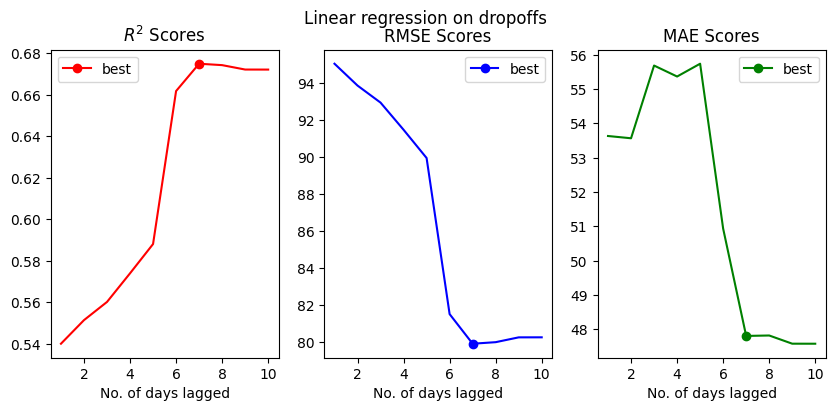

In [ ]:
plot_metrics(r2_scores, rmse_scores, mae_scores, "Linear regression on dropoffs")

The figures above indicate the model using 7 days of lagged features performs best.

	 Size of training set: 6625
	 R^2 Score: 0.6750568153920207
	 RMSE Score: 79.89284258876687
	 MAE Score: 47.81190892956233


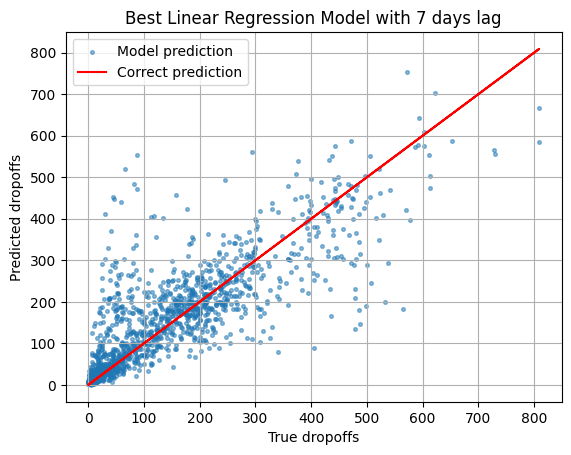

In [ ]:
# Add lagged features to model
f_lagged = f_agg
n_days = max_index+1
for i in range(1,n_days+1):
    f_lagged = buildLaggedFeatures(f_lagged, ['dropoffs'], lag=24*i)

_, predictions, y_test = fit_linear_reg(f_lagged, 'dropoffs')

# Plot predictions and test value
plt.scatter(y_test, predictions, s=7, alpha=0.5, label='Model prediction')
plt.plot(y_test, y_test, c='r', label='Correct prediction')
plt.xlabel('True dropoffs')
plt.ylabel('Predicted dropoffs')
plt.title(f'Best Linear Regression Model with {n_days} days lag')
plt.grid()
plt.legend()
plt.show()

The observations are equivalent to the LR-model for pickups.

### Gradient Boosting Regressor

In [ ]:
# Add lagged features to model
f_lagged = f_agg
r2_scores = []
rmse_scores = []
mae_scores = []

for i in range(1,11):
    print(f"Lag by {i} days")
    f_lagged = buildLaggedFeatures(f_lagged, ['dropoffs'], lag=24*i)

    # Train and evaluate model
    metrics, _, _ = fit_gbr(f_lagged, 'dropoffs')
    r2_scores.append(metrics[0])
    rmse_scores.append(metrics[2])
    mae_scores.append(metrics[3])

# Find max score
max_score = max(r2_scores)
max_index = r2_scores.index(max_score)
print("-------------------------")
print("Best performing model")
print(f"\t R^2 Score: {max_score}")
print(f"\t RMSE Score: {rmse_scores[max_index]}")
print(f"\t MAE Score: {mae_scores[max_index]}")
print(f"\t uses lagged features up till {max_index+1} days")

write_to_output('Dropoffs','GBR',max_index+1,K,
                [max(r2_scores),'NIL',rmse_scores[max_index],mae_scores[max_index]])

Lag by 1 days
	 Size of training set: 7273
	 R^2 Score: 0.41857642150590824
	 RMSE Score: 106.86868789811865
	 MAE Score: 71.58010705660443
Lag by 2 days
	 Size of training set: 7225
	 R^2 Score: 0.56909414606625
	 RMSE Score: 92.00159454076442
	 MAE Score: 61.87547779716605
Lag by 3 days
	 Size of training set: 7153
	 R^2 Score: 0.6164615306132158
	 RMSE Score: 86.79778105516036
	 MAE Score: 57.15440422405903
Lag by 4 days
	 Size of training set: 7057
	 R^2 Score: 0.638763333867009
	 RMSE Score: 84.23645275222823
	 MAE Score: 54.72472428052578
Lag by 5 days
	 Size of training set: 6937
	 R^2 Score: 0.6562651924887691
	 RMSE Score: 82.17049695004381
	 MAE Score: 53.23227516491329
Lag by 6 days
	 Size of training set: 6793
	 R^2 Score: 0.6895252830724425
	 RMSE Score: 78.0939297273591
	 MAE Score: 49.97560241586608
Lag by 7 days
	 Size of training set: 6625
	 R^2 Score: 0.6939698801756212
	 RMSE Score: 77.53293841470065
	 MAE Score: 48.54686193382729
Lag by 8 days
	 Size of training set

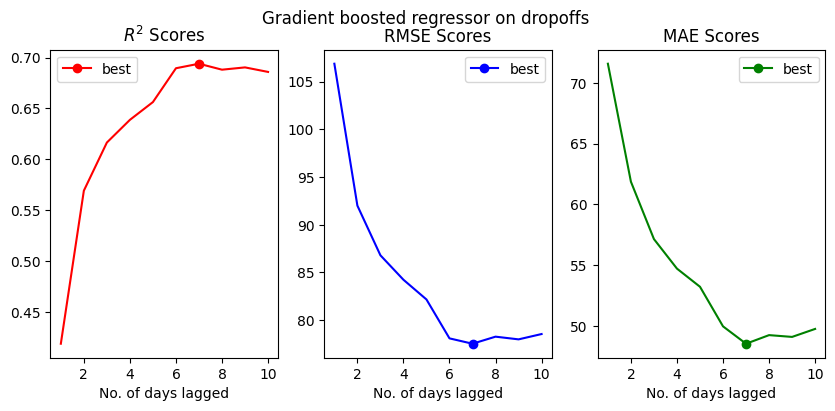

In [ ]:
plot_metrics(r2_scores, rmse_scores, mae_scores, "Gradient boosted regressor on dropoffs")

The figures above indicate the model using 7 days of lagged features performs best.

	 Size of training set: 6625
	 R^2 Score: 0.6939698801756212
	 RMSE Score: 77.53293841470065
	 MAE Score: 48.54686193382729


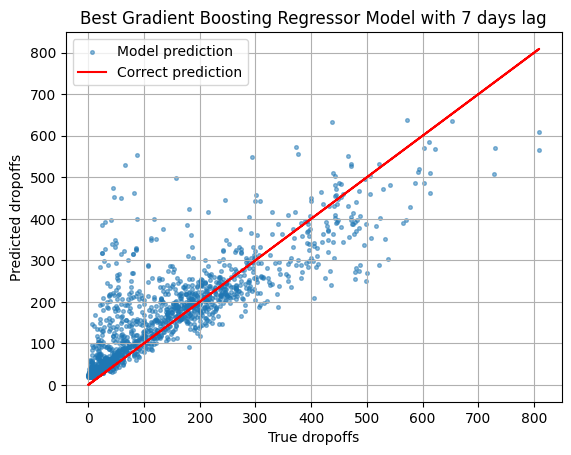

In [ ]:
# Add lagged features to model
f_lagged = f_agg
n_days = max_index+1
for i in range(1,n_days+1):
    f_lagged = buildLaggedFeatures(f_lagged, ['dropoffs'], lag=24*i)

_, predictions, y_test = fit_gbr(f_lagged, 'dropoffs')

# Plot predictions and test value
plt.scatter(y_test, predictions, s=7, alpha=0.5, label='Model prediction')
plt.plot(y_test, y_test, c='r', label='Correct prediction')
plt.xlabel('True dropoffs')
plt.ylabel('Predicted dropoffs')
plt.title(f'Best Gradient Boosting Regressor Model with {n_days} days lag')
plt.grid()
plt.legend()
plt.show()

The observations are equivalent to the GBR-model for pickups. As opposed to the pickups, overestimation can lead to bike shortages.

## Iterating through different cluster sizes
The models are retrained with different cluster sizes to improve performance. The functions from the previous sections are used.

In [ ]:
def get_modelling_df(f: pd.DataFrame, k:int, target_var:str) -> pd.DataFrame:
  """
  Runs KMeans and returns a df containing the largest cluster.

  Parameters
  --------------
  f : pandas.DataFrame
  k : int
    No. of clusters for KMeans
  target_var : str
    "pickups" or "dropoffs"

  Return
  --------------
  f_model : pandas.DataFrame
  """
  # Run KMeans
  KM = KMeans(n_clusters=k, n_init='auto', random_state=10)
  KM.fit(coordinates)

  # Create a dictionary matching the station_id and clusters found
  keys = start_stations['start_station_id'].to_list()
  values = KM.labels_
  clusters_dict = {keys[i]: values[i] for i in range(len(keys))}

  # Add new column for cluster id
  f['start_cluster_id'] = f['start_station_id'].map(clusters_dict)
  f['end_cluster_id'] = f['end_station_id'].map(clusters_dict)

  # Count the number of entries for each cluster
  cluster_count_series = f['start_cluster_id'].value_counts()
  max_cluster = cluster_count_series.index[0]

  # Extract entries from largest cluster
  if target_var == "pickups":
    f_model = f.loc[f['start_cluster_id']==max_cluster]
  elif target_var == "dropoffs":
    f_model = f.loc[f['end_cluster_id']==max_cluster]
  else:
    raise ValueError("Invalid target variable given")

  return f_model


In [ ]:
def aggregate_df(f:pd.DataFrame, target_var:str) -> pd.DataFrame:
  """
  Aggregates the df hourly and sums the target variable.

  Parameters
  --------------
  f : pandas.DataFrame
  target_var : str
    "pickups" or "dropoffs"

  Return
  --------------
  f_agg : pandas.DataFrame
  """
  if target_var == "pickups":
    f.set_index('starttime', inplace=True)
  elif target_var == "dropoffs":
    f.set_index('stoptime', inplace=True)
  else:
    raise ValueError("Invalid target variable given")
  f.loc[:,(target_var)] = 1
  f_agg = f.resample("1H").agg({target_var:'sum'})
  return f_agg

In [ ]:
def run_prediction_models(f:pd.DataFrame, k:int, target_var:str):
  """
  Extracts relevant df, aggregates df based on the target_var, and fits
  the prediction models. Returns the model metrics.

  Parameters
  --------------
  f : pandas.DataFrame
  k : int
    No. of clusters for KMeans
  target_var : str
    "pickups" or "dropoffs"

  Return
  --------------
  r2_scores, mse_scores, rmse_scores, mae_scores
  """
  print(f"Running k={k} clusters")

  # Prepare relevant dataframe
  f_model = get_modelling_df(f, k, target_var)
  f_agg = aggregate_df(f_model, target_var)

  # Initialise array for metrics
  n_lag_days = 10
  n_models = 3
  r2_scores = np.empty((n_lag_days,n_models))
  mse_scores = np.empty((n_lag_days,n_models))
  rmse_scores = np.empty((n_lag_days,n_models))
  mae_scores = np.empty((n_lag_days,n_models))

  # Add lagged features to model
  f_lagged = f_agg
  for i in tqdm(range(1, n_lag_days+1)):
    print("\r \t Fitting up to {} days lag".format(i), end="")
    f_lagged = buildLaggedFeatures(f_lagged, [target_var], lag=24*i)

    # Train and evaluate models
    metrics_base, _, _ = fit_baseline(f_lagged, target_var, verbose=False)
    metrics_lr, _, _ = fit_linear_reg(f_lagged, target_var, verbose=False)
    metrics_gbr, _, _ = fit_gbr(f_lagged, target_var, verbose=False)

    # [r2, mse, rmse, mae]
    r2_scores[i-1] = [metrics_base[0], metrics_lr[0], metrics_gbr[0]]
    mse_scores[i-1] = [metrics_base[1], metrics_lr[1], metrics_gbr[1]]
    rmse_scores[i-1] = [metrics_base[2], metrics_lr[2], metrics_gbr[2]]
    mae_scores[i-1] = [metrics_base[3], metrics_lr[3], metrics_gbr[3]]

  return r2_scores, mse_scores, rmse_scores, mae_scores

In [ ]:
# For pickups
for k in [20, 25, 30, 35, 40, 45]:
  r2_scores, mse_scores, rmse_scores, mae_scores = run_prediction_models(f, k, 'pickups')

  # Find best scores
  print("\n\n\t Models: [baseline linear_regression gradient_boosted_regressor]")
  print(f"\t max r2: {r2_scores.max(axis=0)}")
  print(f"\t\t days: {np.argmax(r2_scores,axis=0)+1}")
  print(f"\t min mse: {mse_scores.min(axis=0)}")
  print(f"\t\t days: {np.argmin(mse_scores,axis=0)+1}")
  print(f"\t min rmse: {rmse_scores.min(axis=0)}")
  print(f"\t\t days: {np.argmin(rmse_scores,axis=0)+1}")
  print(f"\t min mae: {mae_scores.min(axis=0)}")
  print(f"\t\t days: {np.argmin(mae_scores,axis=0)+1}")

  # Write to output file
  best_days = np.argmax(r2_scores,axis=0)+1
  best_r2_scores = r2_scores.max(axis=0)
  best_mse_scores = mse_scores.min(axis=0)
  best_rmse_scores = rmse_scores.min(axis=0)
  best_mae_scores = mae_scores.min(axis=0)
  write_to_output('Pickups','Baseline',best_days[0],k,
                [best_r2_scores[0],best_mse_scores[0],
                 best_rmse_scores[0],best_mae_scores[0]])
  write_to_output('Pickups','Linear Regression',best_days[1],k,
                [best_r2_scores[1],best_mse_scores[1],
                 best_rmse_scores[1],best_mae_scores[1]])
  write_to_output('Pickups','GBR',best_days[2],k,
                [best_r2_scores[2],best_mse_scores[2],
                 best_rmse_scores[2],best_mae_scores[2]])

Running k=20 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag

	 Models: [baseline linear_regression gradient_boosted_regressor]
	 max r2: [0.54838313 0.65260712 0.67808026]
		 days: [8 7 7]
	 min mse: [17118.93528005 13168.23300622 12202.65130317]
		 days: [8 7 7]
	 min rmse: [130.83934913 114.75292156 110.46561141]
		 days: [8 7 7]
	 min mae: [81.2568306  67.95257615 67.66939812]
		 days: [1 9 7]
Running k=25 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag

	 Models: [baseline linear_regression gradient_boosted_regressor]
	 max r2: [0.62211289 0.6480705  0.66573787]
		 days: [9 8 6]
	 min mse: [6831.14016225 6361.89919878 6042.52277125]
		 days: [9 8 6]
	 min rmse: [82.65071181 79.76151452 77.73366562]
		 days: [9 8 6]
	 min mae: [53.74257172 49.13882539 50.13286664]
		 days: [ 8 10  7]
Running k=30 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag

	 Models: [baseline linear_regression gradient_boosted_regressor]
	 max r2: [0.56151904 0.66155281 0.69963743]
		 days: [ 8  7 10]
	 min mse: [11717.24687287  9044.10824436  8026.39720381]
		 days: [ 8  7 10]
	 min rmse: [108.2462326   95.10051653  89.59016243]
		 days: [ 8  7 10]
	 min mae: [65.53483607 54.01928998 53.42815331]
		 days: [ 1 10  7]
Running k=35 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag

	 Models: [baseline linear_regression gradient_boosted_regressor]
	 max r2: [0.56151904 0.66155281 0.69963743]
		 days: [ 8  7 10]
	 min mse: [11717.24687287  9044.10824436  8026.39720381]
		 days: [ 8  7 10]
	 min rmse: [108.2462326   95.10051653  89.59016243]
		 days: [ 8  7 10]
	 min mae: [65.53483607 54.01928998 53.42815331]
		 days: [ 1 10  7]
Running k=40 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag

	 Models: [baseline linear_regression gradient_boosted_regressor]
	 max r2: [0.58729464 0.6553265  0.67812991]
		 days: [8 7 6]
	 min mse: [7288.07815702 6086.68482941 5683.99306941]
		 days: [8 7 6]
	 min rmse: [85.37024164 78.01720855 75.39226134]
		 days: [8 7 6]
	 min mae: [55.05780396 47.20047961 47.9645042 ]
		 days: [ 8 10  7]
Running k=45 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag

	 Models: [baseline linear_regression gradient_boosted_regressor]
	 max r2: [0.62775781 0.65644783 0.68063485]
		 days: [8 8 7]
	 min mse: [4951.73768357 4570.08978343 4248.3428925 ]
		 days: [8 8 7]
	 min rmse: [70.36858449 67.60243918 65.17931338]
		 days: [8 8 7]
	 min mae: [45.47096995 41.1219767  42.02120446]
		 days: [ 8 10  7]


In [ ]:
# For dropoffs
for k in [20, 25, 30, 35, 40, 45]:
  r2_scores, mse_scores, rmse_scores, mae_scores = run_prediction_models(f, k, 'dropoffs')

  # Find best scores
  print(f"\n\t max r2: {r2_scores.max(axis=0)}")
  print(f"\t days: {np.argmax(r2_scores,axis=0)+1}")
  print(f"\t min mse: {mse_scores.min(axis=0)}")
  print(f"\t days: {np.argmin(mse_scores,axis=0)+1}")
  print(f"\t min rmse: {rmse_scores.min(axis=0)}")
  print(f"\t days: {np.argmin(rmse_scores,axis=0)+1}")
  print(f"\t min mae: {mae_scores.min(axis=0)}")
  print(f"\t days: {np.argmin(mae_scores,axis=0)+1}")

  # Write to output file
  best_days = np.argmax(r2_scores,axis=0)+1
  best_r2_scores = r2_scores.max(axis=0)
  best_mse_scores = mse_scores.min(axis=0)
  best_rmse_scores = rmse_scores.min(axis=0)
  best_mae_scores = mae_scores.min(axis=0)
  write_to_output('Dropoffs','Baseline',best_days[0],k,
                [best_r2_scores[0],best_mse_scores[0],
                 best_rmse_scores[0],best_mae_scores[0]])
  write_to_output('Dropoffs','Linear Regression',best_days[1],k,
                [best_r2_scores[1],best_mse_scores[1],
                 best_rmse_scores[1],best_mae_scores[1]])
  write_to_output('Dropoffs','GBR',best_days[2],k,
                [best_r2_scores[2],best_mse_scores[2],
                 best_rmse_scores[2],best_mae_scores[2]])

Running k=20 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag
	 max r2: [0.57038155 0.67372142 0.71079523]
	 days: [8 7 7]
	 min mse: [17739.29744027 13472.30974625 11941.50174326]
	 days: [8 7 7]
	 min rmse: [133.1889539  116.07027934 109.27717851]
	 days: [8 7 7]
	 min mae: [80.98634812 66.97249292 66.26227338]
	 days: [ 1 10  7]
Running k=25 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag
	 max r2: [0.62849875 0.66613681 0.68554248]
	 days: [8 8 6]
	 min mse: [7411.82818899 6660.91054068 6273.74774617]
	 days: [8 8 6]
	 min rmse: [86.09197517 81.61440155 79.20699304]
	 days: [8 8 6]
	 min mae: [55.0915529  49.680798   50.92207128]
	 days: [ 8 10  7]
Running k=30 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag
	 max r2: [0.55756176 0.68043242 0.72251166]
	 days: [8 7 7]
	 min mse: [12004.6566022   8670.81245072  7529.07834341]
	 days: [8 7 7]
	 min rmse: [109.56576382  93.1171974   86.77026186]
	 days: [8 7 7]
	 min mae: [65.07650273 53.28468575 51.68520736]
	 days: [1 9 7]
Running k=35 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag
	 max r2: [0.55756176 0.68043242 0.72251166]
	 days: [8 7 7]
	 min mse: [12004.6566022   8670.81245072  7529.07834341]
	 days: [8 7 7]
	 min rmse: [109.56576382  93.1171974   86.77026186]
	 days: [8 7 7]
	 min mae: [65.07650273 53.28468575 51.68520736]
	 days: [1 9 7]
Running k=40 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag
	 max r2: [0.60589025 0.67505682 0.69396988]
	 days: [8 7 7]
	 min mse: [7741.50660196 6382.86629691 6011.35653922]
	 days: [8 7 7]
	 min rmse: [87.98583183 79.89284259 77.53293841]
	 days: [8 7 7]
	 min mae: [55.19394198 47.58507874 48.54686193]
	 days: [ 8 10  7]
Running k=45 clusters


  0%|          | 0/10 [00:00<?, ?it/s]

 	 Fitting up to 10 days lag
	 max r2: [0.62457089 0.66652206 0.67960558]
	 days: [8 7 7]
	 min mse: [5372.84404863 4772.47223278 4585.23121048]
	 days: [8 7 7]
	 min rmse: [73.29968655 69.0830821  67.71433534]
	 days: [8 7 7]
	 min mae: [46.80221843 41.71917115 42.75368727]
	 days: [ 8 10  7]


The best models are chosen based on a qualitative assessment of the $R^2$-score and the RMSE. The RMSE has higher priority than the MAE as it increases the importance of outliers. As mentioned, overestimates of the pickups and underestimates of the dropoffs leads to bike shortages. Therefore, the outliers should be kept small.

| Target Variable | Model | No. of lag days | No. of clusters | $R^2$ score | RMSE |
| :-------: | :------- | :-------: | :-------: | :-------: | :-------: |
| Pickups   | BL       | 8         | 45        | 0.63      | 70.37     |
| Pickups   | LR       | 8         | 45        | 0.66      | 67.60     |
| Pickups   | GBR      | 7         | 45        | 0.68      | 65.18     |
| Dropoffs  | BL       | 8         | 45        | 0.62      | 73.30     |
| Dropoffs  | LR       | 7         | 45        | 0.67      | 69.08     |
| Dropoffs  | GBR      | 7         | 45        | 0.68      | 67.71     |


For each target variable, GBR requires fewer lag days than their LR counterparts. Furthermore, the RMSE significantly decreases when using 45 clusters. Lastly, the GBR got the best scores for both $R^2$ and RMSE.

## Bike Shortage
It is of interest to predict the net flux of bikes in a cluster to prevent bike shortages from happening on a given day. This can be achieved by calculating the maximum difference of hourly net pickups.

The models from the previous sections are used to predict the hourly pickups and dropoffs. 45 clusters and 7 lag days are used for all three, 7 days is chosen to use as little data as possible, this will bias towards GBR.

The predicted shortages are compared to the true shortages.


In [ ]:
# Choose cluster size
best_K = 45
best_days = 7

In [ ]:
def plot_all_shortages(f_shortage):
    f_shortage['date'] = f_shortage.index
    f_shortage['day'] = f_shortage['date'].dt.day_name()


    # Bar plot of daily shortages
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_elements = [Patch(facecolor='#1f77b4', label='Weekday'),
                        Patch(facecolor='red', label='Weekend'),
                      Line2D([0], [0], color='k', lw=4, label='True')]

    # True
    plt.plot(f_shortage.index, f_shortage['true_shortage'], color='k', marker='o',
            markersize=3)

    # Predictions
    barlist_pred = plt.bar(f_shortage.index, f_shortage['predicted_shortage'], alpha=0.5)
    plt.ylabel("Predicted shortage")
    plt.legend(handles=legend_elements)
    plt.xticks(rotation=45, ha='right')

    for i in range(len(barlist_pred)):
        if f_shortage['day'][i] == 'Sunday' or f_shortage['day'][i] == 'Saturday':
            barlist_pred[i].set_color('r')
            # barlist_true[i].set_color('r')

    plt.title("Bar plot of daily bike shortages in Nov and Dec")
    plt.show()

In [ ]:
def plot_shortages_by_day(f_shortage):
    # Compute mean of each day of the week
    week_count = f_shortage.groupby('day').mean()

    # Plot bar graph
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                    'Saturday', 'Sunday']
    week_count = week_count.reindex(ordered_days)

    plt.plot(ordered_days, week_count['true_shortage'], color='k', marker='o', label='True')
    plt.bar(ordered_days, week_count['predicted_shortage'], alpha=0.8, label='Predicted')
    plt.xticks(ordered_days, rotation=45, ha='right')
    plt.ylabel("Shortage")
    plt.legend()
    plt.title("Average shortages by day of the week")
    plt.show()

In [ ]:
# Run KMeans
KM = KMeans(n_clusters=best_K, random_state=10)
KM.fit(coordinates)

# Create a dictionary matching the station_id and clusters found
keys = start_stations['start_station_id'].to_list()
values = KM.labels_
clusters_dict = {keys[i]: values[i] for i in range(len(keys))}

# Add new column for cluster id
f['start_cluster_id'] = f['start_station_id'].map(clusters_dict)
f['end_cluster_id'] = f['end_station_id'].map(clusters_dict)

# Count the number of entries for each cluster
cluster_count_series = f['start_cluster_id'].value_counts()
max_cluster = cluster_count_series.index[0]

# Create pickups column
f_cluster_start = f.copy().loc[f['start_cluster_id']==max_cluster]
f_cluster_start.set_index('starttime', inplace=True)
f_cluster_start.loc[:,('pickups')] = 1

# Aggregate hourly, and sum the pickups
f_cluster_start = f_cluster_start.resample("1H").agg({'pickups':'sum'})

# Create dropoffs column
f_cluster_end = f.copy().loc[f['end_cluster_id']==max_cluster]
f_cluster_end.set_index('stoptime', inplace=True)
f_cluster_end['dropoffs'] = 1

# Aggregate hourly, and sum the dropoffs
f_cluster_end = f_cluster_end.resample("1H").agg({'dropoffs':'sum'})

# Join the two dataframes
f_agg = f_cluster_start.join(f_cluster_end)
f_agg.head()

# Add lagged features in 24h intervals
for i in range(1,best_days+1):
    f_agg = buildLaggedFeatures(f_agg, ['dropoffs','pickups'], lag=24*i)

# Split dataset into training and test sets
train = f_agg[:split_date]
test = f_agg[split_date:]

### Baseline

In [ ]:
# Split features for training and test
# drop features that contain the 'dropoffs'
X_train = train.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
y_train = train[['pickups']]
X_test = test.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
y_test = test[['pickups']]
pickup_true = y_test.squeeze()

# Train baseline model
pickup_predictions = X_test.mean(axis=1)

### Selected model for dropoffs

# Split features for training and test
# drop features that contain the 'pickups'
X_train = train.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)
y_train = train[['dropoffs']]
X_test = test.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)
y_test = test[['dropoffs']]
dropoff_true = y_test.squeeze()

# Train baseline model
dropoff_predictions = X_test.mean(axis=1)

shortage_predictions = pickup_predictions - dropoff_predictions
shortage_true = pickup_true - dropoff_true

# Reshape vector into 61days x 24hrs by keeping max value
daily_shortages_pred = shortage_predictions.to_numpy().reshape(-1, 24).max(axis=1)
daily_shortages_true = shortage_true.to_numpy().reshape(-1,24).max(axis=1)

# Add datetime index
idx = y_test.resample("1D").agg({'dropoffs':'sum'}).index
f_shortage = pd.DataFrame()
f_shortage.index = idx
f_shortage['predicted_shortage'] = daily_shortages_pred
f_shortage['true_shortage'] = daily_shortages_true
f_shortage.head()

predicted_shortage  true_shortage
starttime                                    
2018-11-01           78.428571            115
2018-11-02           83.714286             96
2018-11-03           78.285714             50
2018-11-04           70.285714             61
2018-11-05           70.142857            168

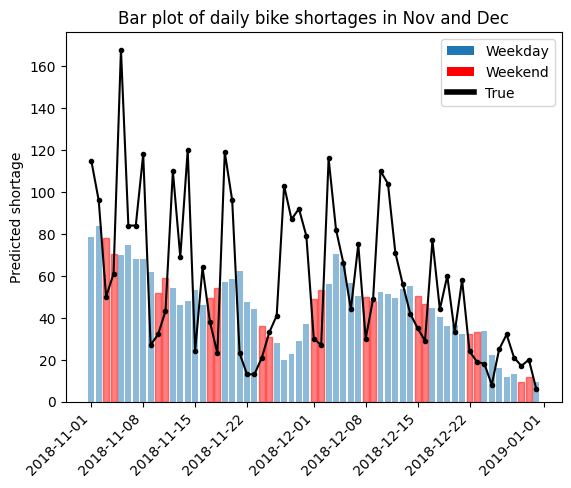

RMSE across Nov and Dec: 24.870142836016058


In [ ]:
plot_all_shortages(f_shortage)
rmse = mean_squared_error(shortage_true, shortage_predictions, squared=False)
print(f"RMSE across Nov and Dec: {rmse}")

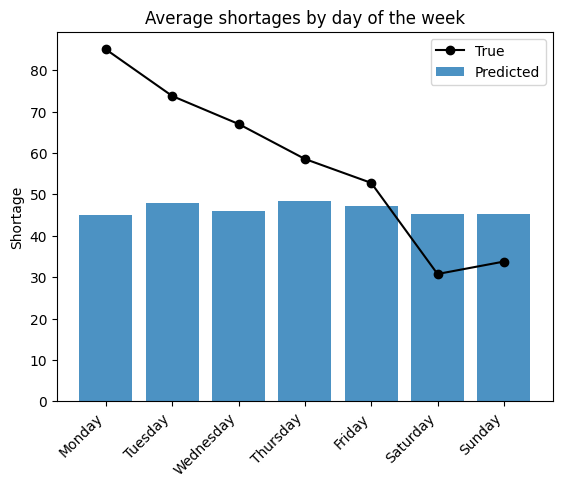

In [ ]:
plot_shortages_by_day(f_shortage)

The BL-model in general fails to predict shortages. It significantly overestiamtes the net flux on the weekends and underestimates in the weekdays, leading to shortages for all days except weekends.

### Linear Regression

In [ ]:
### Selected model for pickups

# Split features for training and test
# drop features that contain the 'dropoffs'
X_train = train.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
y_train = train[['pickups']]
X_test = test.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
y_test = test[['pickups']]
pickup_true = y_test.squeeze()

# Train LR model
pickups_reg = LinearRegression(fit_intercept=False)
pickups_reg.fit(X_train, y_train)

### Selected model for dropoffs

# Split features for training and test
# drop features that contain the 'pickups'
X_train = train.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)
y_train = train[['dropoffs']]
X_test = test.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)
y_test = test[['dropoffs']]
dropoff_true = y_test.squeeze()

# Train LR model
dropoffs_reg = LinearRegression(fit_intercept=False)
dropoffs_reg.fit(X_train, y_train)

# Use test values from Nov and Dec
pickup_test = test.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
dropoff_test = test.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)

# Get predictions LR models
pickup_predictions = pickups_reg.predict(pickup_test)
dropoff_predictions = dropoffs_reg.predict(dropoff_test)
shortage_predictions = pickup_predictions - dropoff_predictions
shortage_true = pickup_true - dropoff_true

# Reshape vector into 61days x 24hrs by keeping max value
daily_shortages_pred = shortage_predictions.reshape(-1, 24).max(axis=1)
daily_shortages_true = shortage_true.to_numpy().reshape(-1,24).max(axis=1)

# Add datetime index
idx = y_test.resample("1D").agg({'dropoffs':'sum'}).index
f_shortage = pd.DataFrame()
f_shortage.index = idx
f_shortage['predicted_shortage'] = daily_shortages_pred
f_shortage['true_shortage'] = daily_shortages_true
f_shortage.head()

predicted_shortage  true_shortage
starttime                                    
2018-11-01           97.099942            115
2018-11-02           97.767560             96
2018-11-03           35.464143             50
2018-11-04           37.597714             61
2018-11-05           91.659123            168

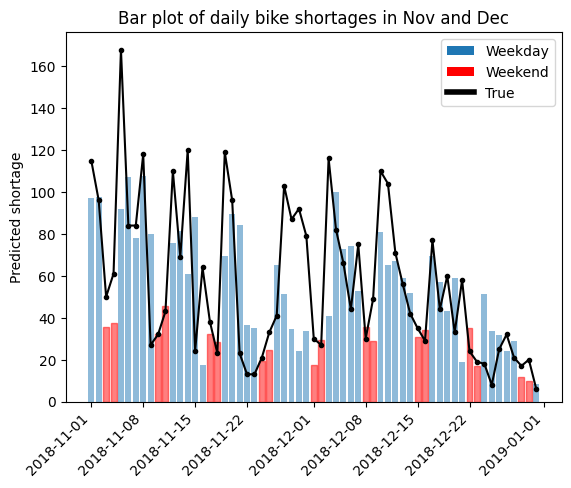

RMSE across Nov and Dec: 23.197329529858756


In [ ]:
plot_all_shortages(f_shortage)
rmse = mean_squared_error(shortage_true, shortage_predictions, squared=False)
print(f"RMSE across Nov and Dec: {rmse}")

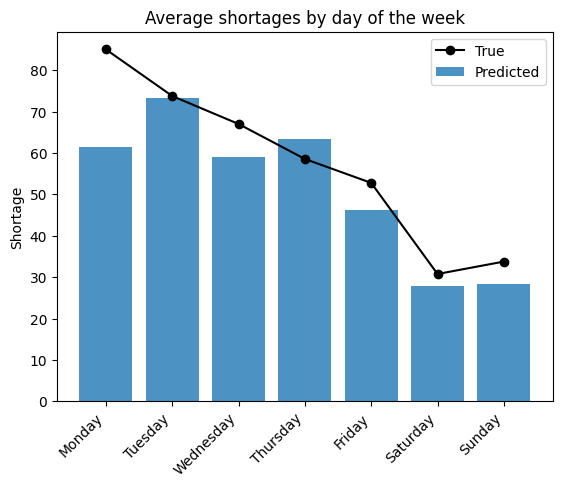

In [ ]:
plot_shortages_by_day(f_shortage)

The LR-model somewhat captures the tendencies of net flux. It works on average for Tuesdays and Thursdays but fails on average for the other days. The LR-model is especially bad on Mondays.

### Gradient Boosted Regressor

In [ ]:
# Define hyperparameters for Gradient Boosted Regressor
learning_rate = 0.01  # Default is 0.1.
n_estimators = 250
max_depth = 10        # Default is 3. Values up to increase complexity.
min_samples_split = 5 # Increasing this can sometimes help in generalization.
min_samples_leaf = 2  # increasing might help in some cases.
max_features = 'log2'   # 'sqrt' or 'log2'.

In [ ]:
### Selected model for pickups

# Split features for training and test
# drop features that contain the 'dropoffs'
X_train = train.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
y_train = train[['pickups']]
X_test = test.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
y_test = test[['pickups']]
pickup_true = y_test.squeeze()

# Train GBR model
pickups_gbr = GradientBoostingRegressor(learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              min_samples_split=min_samples_split,
                              min_samples_leaf=min_samples_leaf,
                              max_features=max_features,
                              random_state=0)
pickups_gbr.fit(X_train, y_train.values.ravel())

### Selected model for dropoffs

# Split features for training and test
# drop features that contain the 'pickups'
X_train = train.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)
y_train = train[['dropoffs']]
X_test = test.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)
y_test = test[['dropoffs']]
dropoff_true = y_test.squeeze()

# Train GBR model
dropoffs_gbr = GradientBoostingRegressor(learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              min_samples_split=min_samples_split,
                              min_samples_leaf=min_samples_leaf,
                              max_features=max_features,
                              random_state=0)
dropoffs_gbr.fit(X_train, y_train.values.ravel())

# Use test values from Nov and Dec
pickup_test = test.drop(list(train.filter(regex='dropoffs'))+['pickups'], axis=1)
dropoff_test = test.drop(list(train.filter(regex='pickups'))+['dropoffs'], axis=1)

# Get predictions for GBR models
pickup_predictions = pickups_gbr.predict(pickup_test)
dropoff_predictions = dropoffs_gbr.predict(dropoff_test)
shortage_predictions = pickup_predictions - dropoff_predictions
shortage_true = pickup_true - dropoff_true

# Reshape vector into 61days x 24hrs by keeping max value
daily_shortages_pred = shortage_predictions.reshape(-1, 24).max(axis=1)
daily_shortages_true = shortage_true.to_numpy().reshape(-1,24).max(axis=1)

# Add datetime index
idx = y_test.resample("1D").agg({'dropoffs':'sum'}).index
f_shortage = pd.DataFrame()
f_shortage.index = idx
f_shortage['predicted_shortage'] = daily_shortages_pred
f_shortage['true_shortage'] = daily_shortages_true
f_shortage.head()

predicted_shortage  true_shortage
starttime                                    
2018-11-01           81.304853            115
2018-11-02          100.722924             96
2018-11-03           58.931244             50
2018-11-04           57.188063             61
2018-11-05           50.057828            168

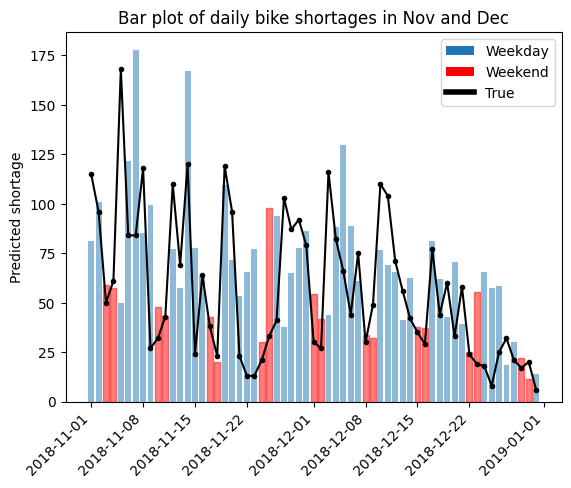

RMSE across Nov and Dec: 28.251373477716623


In [ ]:
plot_all_shortages(f_shortage)
rmse = mean_squared_error(shortage_true, shortage_predictions, squared=False)
print(f"RMSE across Nov and Dec: {rmse}")

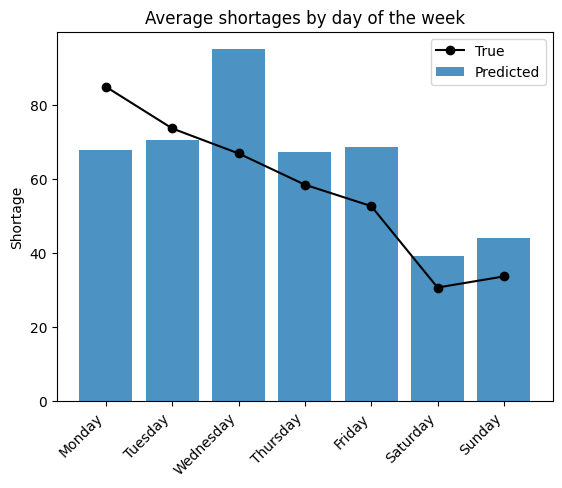

In [ ]:
plot_shortages_by_day(f_shortage)

The GBR-model shows improvement compared to the LR-model. On average it underestimates on Mondays and Tuesdays but delivers satisfying results for the other days. Furthermore, the errors are smaller.

# Exploratory

## Motivation

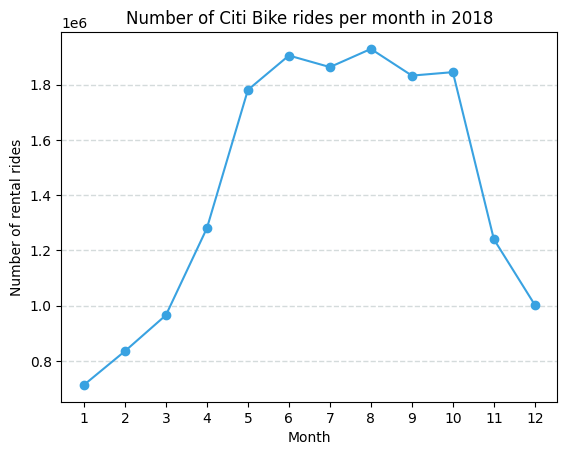

In [ ]:
cb1 = filtered_df.copy()
cb1['starttime'] = pd.to_datetime(cb1['starttime'])
cb1.set_index('starttime', inplace=True)
cb1_monthly = cb1.resample('M').size()# Resample to get monthly counts
plt.plot(cb1_monthly.index.month, cb1_monthly.values, marker='o', linestyle='-', color='#39A2E1')
plt.title('Number of Citi Bike rides per month in 2018')
plt.xlabel('Month')
plt.ylabel('Number of rental rides')
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.4)
plt.xticks(range(1, 13), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.show()

The overall trend of Citi Bike usage in 2018 has been from low to high, with the lowest Citi Bike usage in January, and then usage increasing month by month until the highest usage was seen in August. Usage began to decline in October. This may be due to seasonal and temperature factors.

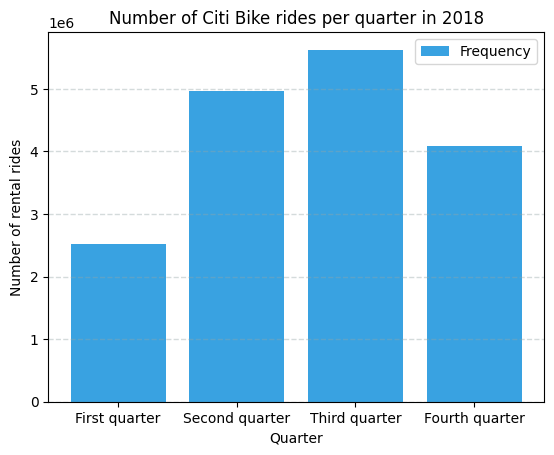

In [ ]:
cb1_quarterly=cb1.resample('Q').size()#Counting of ride data by quarter
plt.bar(cb1_quarterly.index.quarter, cb1_quarterly.values, color='#39A2E1')
plt.title('Number of Citi Bike rides per quarter in 2018')
plt.xlabel('Quarter')
plt.ylabel('Number of rental rides')
plt.legend(['Frequency'], loc='upper right')
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.4)
plt.xticks(range(1, 5), ['First quarter', 'Second quarter', 'Third quarter', 'Fourth quarter'])
plt.show()

We summarize and compare the riding data by quarter, the use of Citi Bike is affected by seasonal factors, with the first quarter having the lowest temperatures and lower Citi Bike usage. The second quarter, the third quarter, is the turn of summer and autumn and has the highest usage. Hence, we decide to explore the relation between total trip and average trip duration and weather variables.

## Load and merge weather data

In [ ]:
w = pd.read_csv('/content/drive/MyDrive/new_york_city_daily_data.csv', index_col=0)

In [ ]:
# make sure w['datetime'] is of type datetime and then convert it to date format
w['datetime'] = pd.to_datetime(w['datetime']).dt.date
# set datetime to the index of w
w.set_index('datetime', inplace=True)
w.head()

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2018-01-01     -4.5    -12.2  -8.7          -5.2         -18.3      -13.3   
2018-01-02     -1.7     -8.9  -6.1          -7.2         -16.9      -12.7   
2018-01-03      0.5     -7.8  -4.1          -1.1         -14.6       -8.7   
2018-01-04     -0.1     -5.7  -2.9          -3.9          -9.8       -6.9   
2018-01-05     -4.6    -11.2  -8.3          -8.2         -16.2      -13.0   

             dew  humidity  precip  precipprob  ...  solarenergy uvindex  \
datetime                                        ...                        
2018-01-01 -15.7      58.0   0.000           0  ...          9.2       5   
2018-01-02 -12.4      61.4   0.000           0  ...          9.0       5   
2018-01-03 -11.8      55.8   5.402         100  ...          7.9       4   
2018-01-04  -6.8      75.9   1.301         100  ...          0.9       1   
2018-01-05 -15.1      58.8   0.000           0  ...          9.6       5   

            severerisk              sunrise               sunset  moonphase  \
datetime                                                                      
2018-01-01         NaN  2018-01-01T07:20:10  2018-01-01T16:39:19       0.50   
2018-01-02         NaN  2018-01-02T07:20:15  2018-01-02T16:40:11       0.52   
2018-01-03         NaN  2018-01-03T07:20:18  2018-01-03T16:41:04       0.55   
2018-01-04         NaN  2018-01-04T07:20:19  2018-01-04T16:41:58       0.59   
2018-01-05         NaN  2018-01-05T07:20:18  2018-01-05T16:42:54       0.62   

                      conditions  \
datetime                           
2018-01-01                 Clear   
2018-01-02                 Clear   
2018-01-03            Snow, Rain   
2018-01-04  Snow, Rain, Overcast   
2018-01-05                 Clear   

                                                  description       icon  \
datetime                                                                   
2018-01-01               Clear conditions throughout the day.  clear-day   
2018-01-02               Clear conditions throughout the day.  clear-day   
2018-01-03  Clear conditions throughout the day with rain ...       snow   
2018-01-04  Cloudy skies throughout the day with a chance ...       snow   
2018-01-05               Clear conditions throughout the day.       snow   

                                                     stations  
datetime                                                       
2018-01-01       72505394728,72055399999,KLGA,KJRB,KNYC,F1417  
2018-01-02  72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7...  
2018-01-03       72505394728,72055399999,KLGA,KJRB,KNYC,F1417  
2018-01-04  72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7...  
2018-01-05       72505394728,72055399999,KLGA,KJRB,KNYC,F1417  

[5 rows x 31 columns]

In [ ]:
#Extract the date from 'starttime' and create a new column 'datetime'
filtered_df['datetime'] = filtered_df['starttime'].dt.date

#Aggregate Citi Bike data to daily level, count the number of trips per day
daily_trips = filtered_df.groupby('datetime').size().reset_index(name='trip_count')
average_duration = filtered_df.groupby('datetime')['tripduration'].mean()

#Merge the aggregated Citi Bike data with the weather data on the 'datetime' column
merged_data = pd.merge(daily_trips, w, left_on='datetime', right_index=True)
merged_data.set_index('datetime', inplace=True)
average_duration = filtered_df.groupby('datetime')['tripduration'].mean()
merged_data['average_duration'] = average_duration

#Reindex the DataFrame with the new column order
columns = merged_data.columns.tolist()
new_order = ['trip_count', 'average_duration'] + [col for col in columns if col not in ['trip_count', 'average_duration']]
merged_data = merged_data[new_order]

In [ ]:
merged_data.head()

trip_count  average_duration  tempmax  tempmin  temp  \
datetime                                                           
2018-01-01        5438        566.967819     -4.5    -12.2  -8.7   
2018-01-02       18721        591.852625     -1.7     -8.9  -6.1   
2018-01-03       24172        600.406462      0.5     -7.8  -4.1   
2018-01-04        1897        684.033210     -0.1     -5.7  -2.9   
2018-01-05        4910        711.923625     -4.6    -11.2  -8.3   

            feelslikemax  feelslikemin  feelslike   dew  humidity  ...  \
datetime                                                           ...   
2018-01-01          -5.2         -18.3      -13.3 -15.7      58.0  ...   
2018-01-02          -7.2         -16.9      -12.7 -12.4      61.4  ...   
2018-01-03          -1.1         -14.6       -8.7 -11.8      55.8  ...   
2018-01-04          -3.9          -9.8       -6.9  -6.8      75.9  ...   
2018-01-05          -8.2         -16.2      -13.0 -15.1      58.8  ...   

            solarenergy  uvindex  severerisk              sunrise  \
datetime                                                            
2018-01-01          9.2        5         NaN  2018-01-01T07:20:10   
2018-01-02          9.0        5         NaN  2018-01-02T07:20:15   
2018-01-03          7.9        4         NaN  2018-01-03T07:20:18   
2018-01-04          0.9        1         NaN  2018-01-04T07:20:19   
2018-01-05          9.6        5         NaN  2018-01-05T07:20:18   

                         sunset  moonphase            conditions  \
datetime                                                           
2018-01-01  2018-01-01T16:39:19       0.50                 Clear   
2018-01-02  2018-01-02T16:40:11       0.52                 Clear   
2018-01-03  2018-01-03T16:41:04       0.55            Snow, Rain   
2018-01-04  2018-01-04T16:41:58       0.59  Snow, Rain, Overcast   
2018-01-05  2018-01-05T16:42:54       0.62                 Clear   

                                                  description       icon  \
datetime                                                                   
2018-01-01               Clear conditions throughout the day.  clear-day   
2018-01-02               Clear conditions throughout the day.  clear-day   
2018-01-03  Clear conditions throughout the day with rain ...       snow   
2018-01-04  Cloudy skies throughout the day with a chance ...       snow   
2018-01-05               Clear conditions throughout the day.       snow   

                                                     stations  
datetime                                                       
2018-01-01       72505394728,72055399999,KLGA,KJRB,KNYC,F1417  
2018-01-02  72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7...  
2018-01-03       72505394728,72055399999,KLGA,KJRB,KNYC,F1417  
2018-01-04  72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7...  
2018-01-05       72505394728,72055399999,KLGA,KJRB,KNYC,F1417  

[5 rows x 33 columns]

## Correlation Analysis

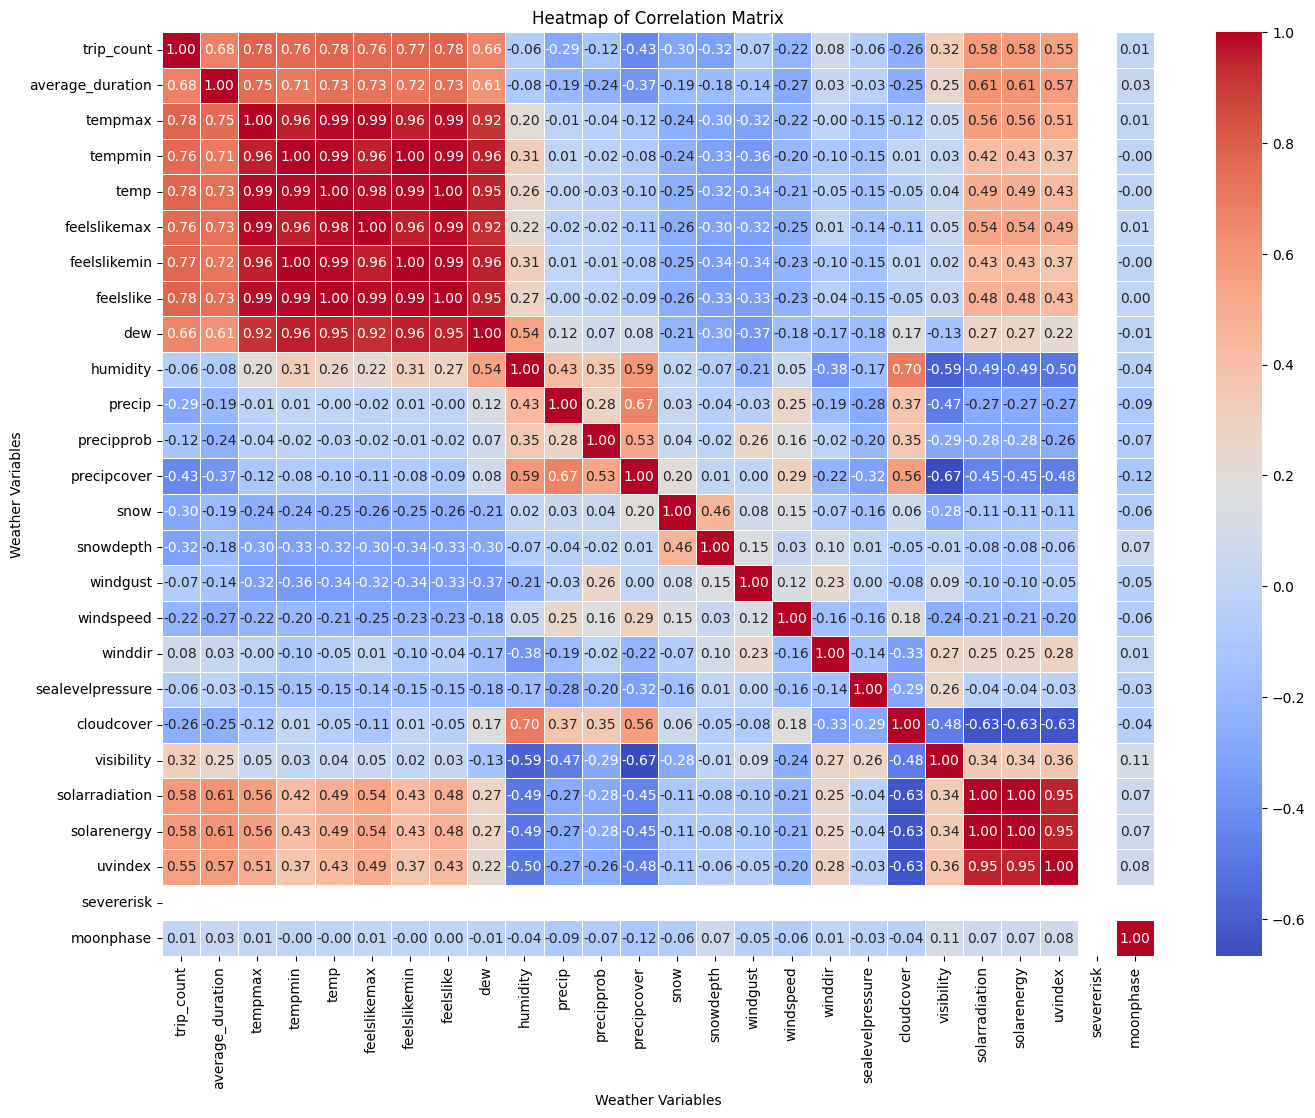

In [ ]:
# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Create the heatmap using Seaborn
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Add titles and labels for clarity
plt.title('Heatmap of Correlation Matrix')
plt.xlabel('Weather Variables')
plt.ylabel('Weather Variables')
plt.show()

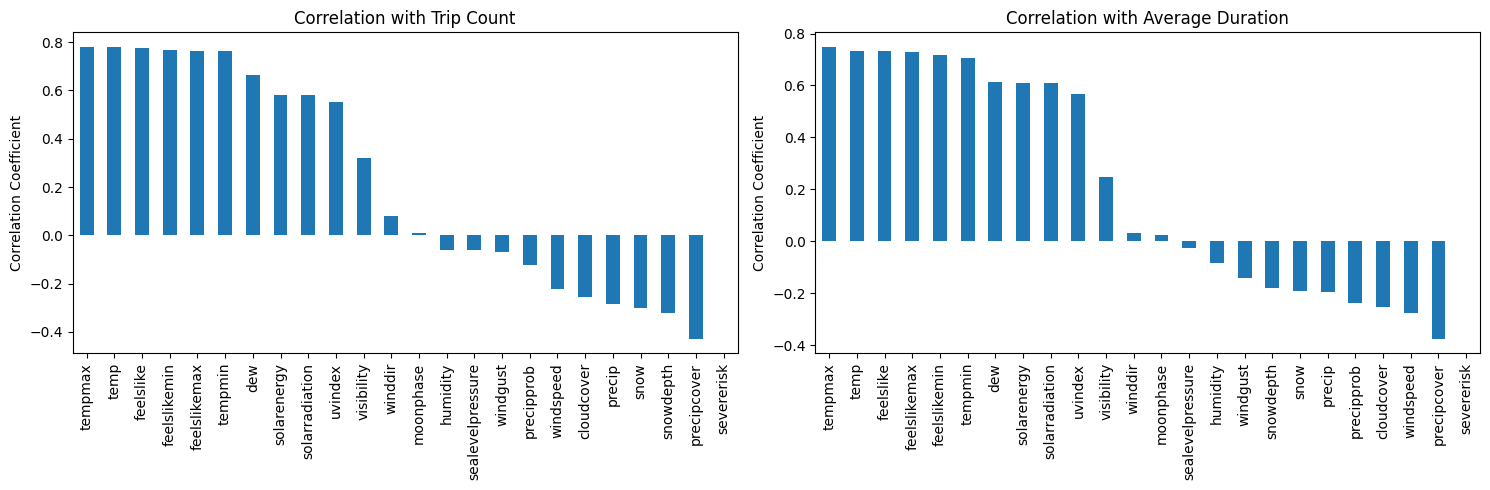

In [ ]:
# calculate the correlation matrix for the merged data
correlation_matrix = merged_data.corr()

# We focus on the correlations of weather variables with both trip count and average duration
trip_count_correlations = correlation_matrix['trip_count'].sort_values(ascending=False)
average_duration_correlations = correlation_matrix['average_duration'].sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

trip_count_correlations.drop(['trip_count', 'average_duration']).plot(kind='bar', ax=axes[0])
axes[0].set_title('Correlation with Trip Count')
axes[0].set_ylabel('Correlation Coefficient')

average_duration_correlations.drop(['trip_count', 'average_duration']).plot(kind='bar', ax=axes[1])
axes[1].set_title('Correlation with Average Duration')
axes[1].set_ylabel('Correlation Coefficient')

plt.tight_layout()
plt.show()


The data visualizations, including a heat map of the correlation matrix and bar graphs depicting weather variables against daily bicycle trips and average trip duration, suggest clear patterns in how weather influences cycling habits.

Higher temperatures show a robust positive correlation with both the frequency and length of bicycle trips, affirming the premise that pleasant weather encourages cycling. Solar radiation follows a similar trend, with increased sunshine likely leading to more frequent and extended bicycle use.Better visibility is moderately associated with higher bicycle usage, which aligns with the idea that clear conditions are preferred and safer for cyclists. On the contrary, windspeed has an inverse relationship with cycling frequency , implying that bad conditions might deter cyclists due to the extra effort required or perceived risks. Precipitation, including rain or snow, is inversely correlated with bicycle usage, supporting the notion that adverse weather conditions deter cycling by affecting comfort and safety.

## Seasonal Decomposition

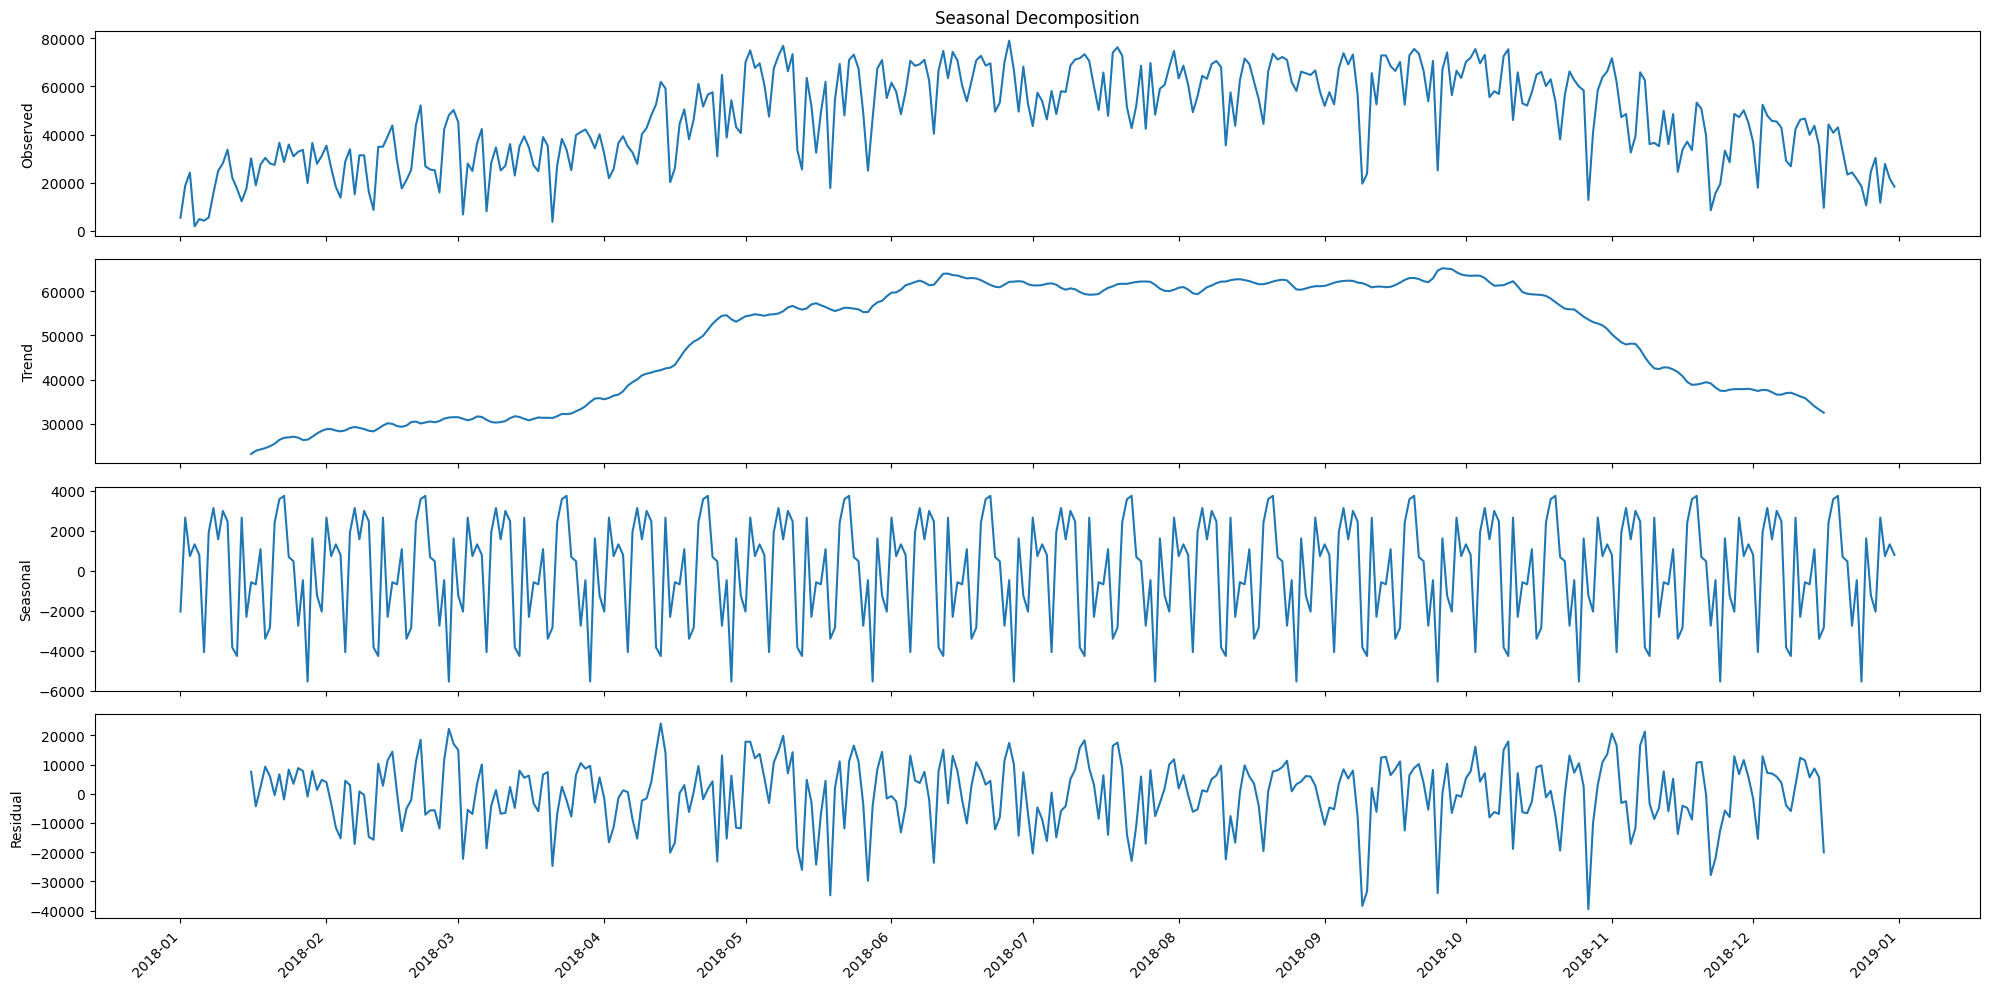

In [ ]:
decomposition = seasonal_decompose(merged_data['trip_count'], model='additive', period=30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

# Plot each component
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')

ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.setp(ax1.xaxis.get_majorticklabels(), visible=False)
plt.setp(ax2.xaxis.get_majorticklabels(), visible=False)
plt.setp(ax3.xaxis.get_majorticklabels(), visible=False)
plt.tight_layout()
plt.show()


In the seasonal decomposition, the bicycle trip counts are broken down into three components: trend, seasonality, and residuals.

Trend shows a clear upward trend in the data until about mid-year, followed by a downward trend. This could indicate that bike use increases as the weather warms, peaks, and then decreases as the weather turns colder.

The seasonal component captures a regular pattern of data over a fixed period of time. The patterns become strong and consistent over time. These fluctuations may be shown to correspond to weekly or monthly changes in bicycle use.

The residuals represent irregularities that are neither trends nor seasonal variations, and may include random or irregular effects not accounted for by the model. This could include random weather events, urban events, or other non-cyclical factors.

## Pair plots

### Relationship between weather variables and trip count for different seasons

Pair plots help us visualize the relationships between multiple variables. We have chosen three of the weather variables: maximum temperature, precipitation cover and snow. By creating a scatterplot grid, it is possible to understand the correlation and distribution of each variable with respect to each of the others.

In [ ]:
#generate seasonal-labeled dataframe

def get_season(datetime):
    month = datetime.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to each date in the index to create the 'season' column
merged_data['season'] = merged_data.index.map(get_season)



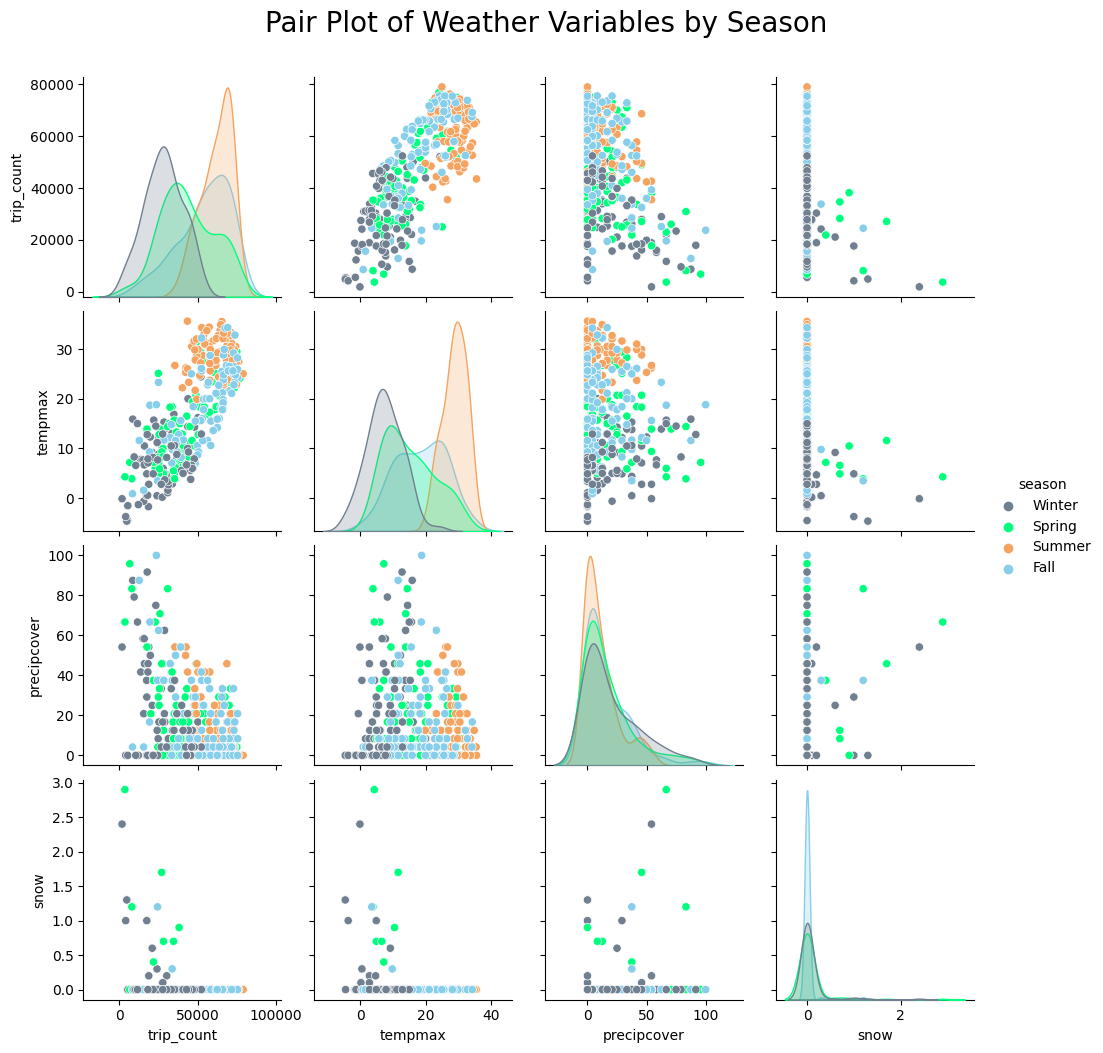

In [ ]:
season_palette = {'Winter': 'slategray', 'Spring': 'springgreen', 'Summer': 'sandybrown', 'Fall': 'skyblue'}

sns.pairplot(data=merged_data, vars=['trip_count', 'tempmax', 'precipcover', 'snow'], hue='season', palette=season_palette)

plt.suptitle('Pair Plot of Weather Variables by Season', size=20, y=1.05)
plt.show()

### Relationship between weather variables and average trip duration for different seasons

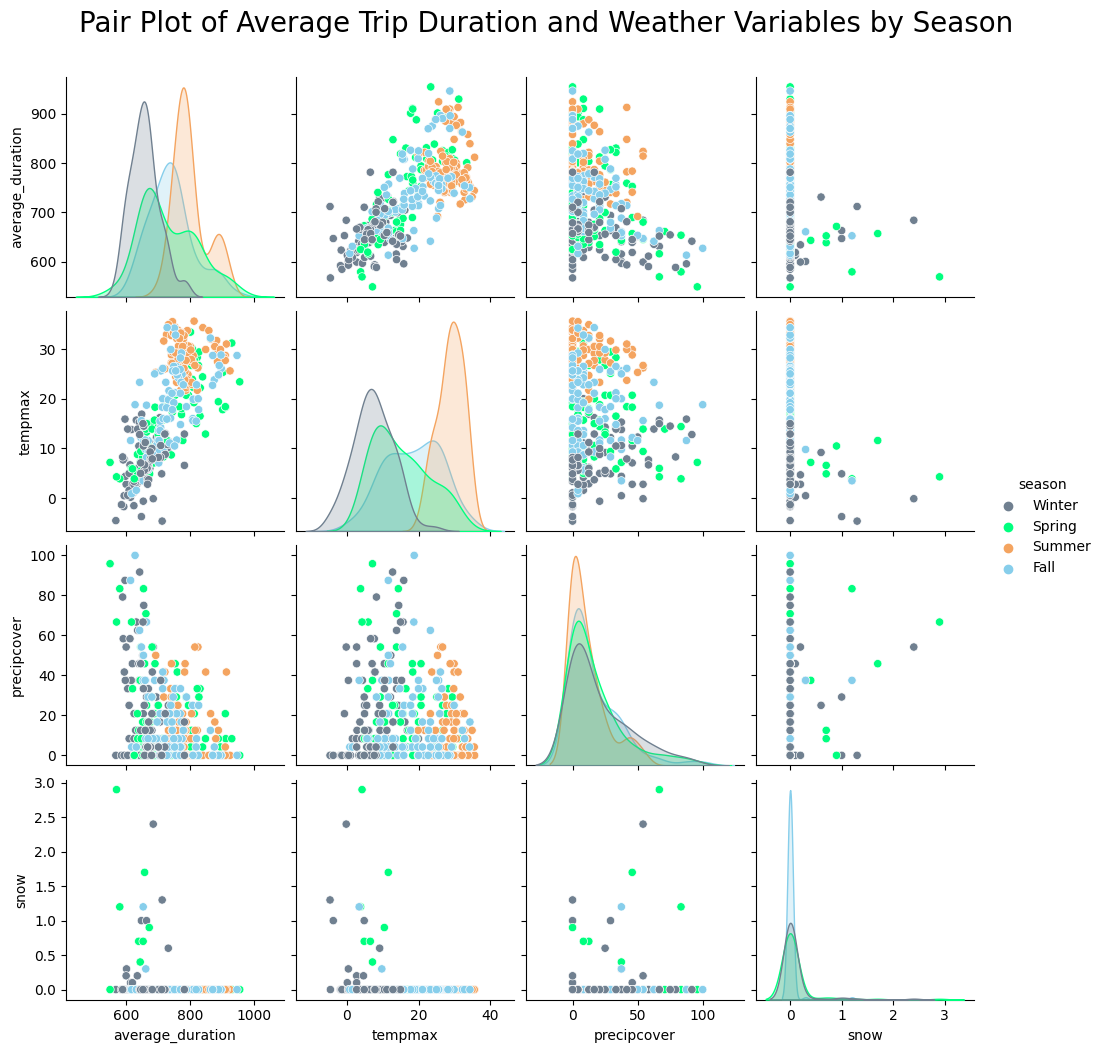

In [ ]:
season_palette = {'Winter': 'slategray', 'Spring': 'springgreen', 'Summer': 'sandybrown', 'Fall': 'skyblue'}

sns.pairplot(data=merged_data, vars=['average_duration', 'tempmax', 'precipcover', 'snow'], hue='season', palette=season_palette)

plt.suptitle('Pair Plot of Average Trip Duration and Weather Variables by Season', size=20, y=1.05)
plt.show()


## Regression Analysis

We employed regression analysis to quantify the relationships between various weather conditions and bicycle usage. Initially, we selected a set of predictor variables( temperature, precipitation, and wind speed )to assess their impact on two key response variables: the number of bicycle trips and the average trip duration. Subsequently, we expanded our analysis to include additional predictors such as precipitation coverage and snow, continuing to examine their influence on the same response variables to gain a deeper understanding of how different weather elements affect cycling trends.

**Multiple Regression for Trip Count: max temperature, precipitation, and windspeed**

In [ ]:
X = merged_data[['tempmax', 'precip', 'windspeed']]
X = sm.add_constant(X)
y = merged_data['trip_count']

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     261.7
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           3.44e-90
Time:                        14:36:14   Log-Likelihood:                -3901.3
No. Observations:                 365   AIC:                             7811.
Df Residuals:                     361   BIC:                             7826.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.212e+04   2228.229      9.926      0.0

<table>
<caption> OLS regression for trip count (R-squared: 0.685) </caption>
<tr>
<th> Variable </th>
<th> Correlation Coefficient </th>
<th> p-value </th>
<th> Impact </th>
</tr>
</thead>
<tbody>
<tr>
<td> Temperature </td>
<td> 1478.74 </td>
<td> p < 0.001 </td>
<td> Considerable positive impact </td>
</tr>
<tr>
<td> Precipitation </td>
<td> -744.43 </td>
<td> p < 0.001 </td>
<td> Considerable negative impact </td>
</tr>
<tr>
<td> Wind Speed </td>
<td> 59.3 </td>
<td> p = 0.47 </td>
<td> Not a reliable indicator </td>
</tr>
</tbody>
</table>



**Multiple Regression for average trip duration: max temperature, precipitation, and windspeed**

In [ ]:
X = merged_data[['tempmax', 'precip', 'windspeed']]
X = sm.add_constant(X)
y = merged_data['average_duration']

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:       average_duration   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     179.1
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           3.98e-71
Time:                        14:38:11   Log-Likelihood:                -1964.2
No. Observations:                 365   AIC:                             3936.
Df Residuals:                     361   BIC:                             3952.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        647.7678     11.041     58.668      0.0

<table border="1">
  <caption> OLS regression for average trip duration (R-squared: 0.598) </caption>
  <tr>
    <th> Variable </th>
    <th> correlation coefficient </th>
    <th> p-value </th>
    <th> impact </th>
  </tr>
  <tr>
    <td> Temperature </td>
    <td> 6.07 </td>
    <td>p &lt; 0.001 </td>
    <td> considerable positive impact </td>
  </tr>
  <tr>
    <td> Precipitation </td>
    <td> -1.94 </td>
    <td>p &lt; 0.001 </td>
    <td> considerable negative impact </td>
  </tr>
  <tr>
    <td> Wind Speed </td>
    <td> -0.78 </td>
    <td> p = 0.053 </td>
    <td> not a reliable indicator </td>
  </tr>
</table>


The regression analysis on Citi Bike data shows temperature positively affects trip count and duration, while precipitation reduces them. Wind speed has a minimal negative impact on duration but doesn't significantly affect trip count. These factors explain 68.5% of the variation in trip count and 59.8% in trip duration, indicating a good fit of the model to the data and highlighting how weather influences cycling habits.

**Multiple Regression for Trip Count: max temperature, precipitation cover, and snow**

In [ ]:
X = merged_data[['tempmax', 'precipcover', 'snow']]
X = sm.add_constant(X)
y = merged_data['trip_count']

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     318.9
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          4.18e-101
Time:                        14:46:26   Log-Likelihood:                -3875.9
No. Observations:                 365   AIC:                             7760.
Df Residuals:                     361   BIC:                             7775.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         2.81e+04   1201.570     23.389      

<table border="1">
  <caption> OLS regression for trip count (R-squared: 0.726) </caption>
  <tr>
    <th> Variable </th>
    <th> correlation coefficient </th>
    <th> p-value </th>
    <th> impact </th>
  </tr>
  <tr>
    <td> Temperature </td>
    <td> 1375.64 </td>
    <td>p &lt; 0.001 </td>
    <td> considerable positive impact </td>
  </tr>
  <tr>
    <td> Precipitation cover </td>
    <td> -309.8 </td>
    <td> p &lt; 0.001 </td>
    <td> considerable negative impact </td>
  </tr>
  <tr>
    <td> Snow </td>
    <td> -4191.7 </td>
    <td> p = 0.043 </td>
    <td> not a reliable indicator </td>
  </tr>
</table>


**Multiple regression for average trip duration: max temperature, precipitation cover, and snow**

In [ ]:
X = merged_data[['tempmax', 'precipcover', 'snow']]
X = sm.add_constant(X)
y = merged_data['average_duration']

model = sm.OLS(y, X).fit()

model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:       average_duration   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     218.3
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           9.45e-81
Time:                        14:46:29   Log-Likelihood:                -1941.7
No. Observations:                 365   AIC:                             3891.
Df Residuals:                     361   BIC:                             3907.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         645.0188      6.003    107.447      

In the regression analysis, temperature is identified as a significant predictor for both trip count and average trip duration. Precipitation cover shows a significant negative correlation with both trip count and trip duration, suggesting fewer trips and shorter durations on days with more precipitation. Snow's effects on occasions  are not statistically significant, indicating its predictive power for trip duration is uncertain within this model. Overall, the model explains a substantial portion of the variability in both trip count (72.6%) and trip duration (64.5%).

<table border="1">
  <caption> OLS regression for average trip duration (R-squared: 0.645) </caption>
  <tr>
    <th> Variable </th>
    <th> correlation coefficient </th>
    <th> p-value </th>
    <th> impact </th>
  </tr>
  <tr>
    <td> Temperature </td>
    <td> 6.01 </td>
    <td> p &lt; 0.001 </td>
    <td> considerable positive impact </td>
  </tr>
  <tr>
    <td> Precipitation cover </td>
    <td> -1.23 </td>
    <td> p &lt; 0.001 </td>
    <td> considerable negative impact </td>
  </tr>
  <tr>
    <td> Snow </td>
    <td> 14.66 </td>
    <td> p = 0.16 </td>
    <td> not a reliable indicator </td>
  </tr>
</table>


**SARIMAX model**


In [ ]:
merged_data.sort_index(inplace=True)

y = merged_data['average_duration']
X = merged_data[['tempmax', 'precip', 'windspeed', 'snow', 'precipcover']]

sarima_model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(sarima_model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                   average_duration   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1871.856
Date:                            Sun, 03 Dec 2023   AIC                           3763.713
Time:                                    14:45:23   BIC                           3802.349
Sample:                                01-01-2018   HQIC                          3779.088
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
tempmax         5.9645      0.514     11.605      0.000       4.957       6.972
precip          0.4341      0.56

<table border="1">
  <caption> SARIMAX regression for average trip duration </caption>
  <tr>
    <th> Variable </th>
    <th> correlation coefficient </th>
    <th> p-value </th>
    <th> impact </th>
  </tr>
  <tr>
    <td> Temperature </td>
    <td> 5.96 </td>
    <td> p &lt; 0.001 </td>
    <td> considerable positive impact </td>
  </tr>
  <tr>
    <td> Precipitation </td>
    <td> 0.43 </td>
    <td> p = 0.44 </td>
    <td> not a reliable indicator </td>
  </tr>
  <tr>
    <td> Windspeed </td>
    <td> -0.54 </td>
    <td> p = 0.15 </td>
    <td> not a reliable indicator </td>
  </tr>
  <tr>
    <td> Snow </td>
    <td> 19.01 </td>
    <td> p = 0.11 </td>
    <td> not a reliable indicator </td>
  </tr>
  <tr>
    <td> Precipcover </td>
    <td> -1.25 </td>
    <td> p &lt; 0.001 </td>
    <td> considerable negative impact </td>
  </tr>
</table>


For the SARIMAX model, a table of coefficients can be used to determine the significance of each predictor variable in the model. A significant p-value (usually < 0.05) indicates that the corresponding predictor variable has a statistically significant relationship with average trip duration.

From the analysis it is clear that
Temperature (tempmax) has a significant positive effect on mean trip duration.
Precipitation (precip) is not statistically significant, indicating that it may not have a significant effect on average duration in this model.
Windspeed has a negative coefficient but is not statistically significant.
Snow has a positive coefficient but is not statistically significant, indicating uncertainty about its effect on trip duration.
Precipcover has a significant negative effect on average trip duration.

## Validation

1. Calculation of RMSE and MAPE. These two metrics help us understand how accurate the model is in predicting trip_count and average_duration.
* RMSE: A standard measure of the difference between predicted and actual values.
* MAPE: Provides a percentage representation of the prediction error, which helps to understand the size of the error relative to the true value.
2. Time series cross-validation. We perform cross-validation while maintaining the chronological order of the data. This means using past data to predict future data, rather than randomly splitting training and test sets

**RMSE, MAPE of OLS Model**

It is based on a single split of training (80%) and testing (20%) set, which is useful for getting a preliminary performance estimate.

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
import numpy as np

# Split the dataset
split_point = int(len(merged_data) * 0.8)
train_data = merged_data.iloc[:split_point]
test_data = merged_data.iloc[split_point:]

In [ ]:
# Evaluate model of "trip_count"
X_train = sm.add_constant(train_data[['tempmax', 'precipcover', 'snow']])
y_train = train_data['trip_count']
X_test = sm.add_constant(test_data[['tempmax', 'precipcover', 'snow']])
y_test = test_data['trip_count']

model_trip_count = sm.OLS(y_train, X_train).fit()
predictions_trip_count = model_trip_count.predict(X_test)

rmse_trip_count = mean_squared_error(y_test, predictions_trip_count, squared=False)
mape_trip_count = mean_absolute_percentage_error(y_test, predictions_trip_count)

# Evaluate model of "average_duration"
X_train = sm.add_constant(train_data[['tempmax', 'precipcover', 'snow']])
y_train = train_data['average_duration']
X_test = sm.add_constant(test_data[['tempmax', 'precipcover', 'snow']])
y_test = test_data['average_duration']

model_avg_duration = sm.OLS(y_train, X_train).fit()
predictions_avg_duration = model_avg_duration.predict(X_test)

rmse_avg_duration = mean_squared_error(y_test, predictions_avg_duration, squared=False)
mape_avg_duration = mean_absolute_percentage_error(y_test, predictions_avg_duration)


print(f"Trip Count - RMSE: {rmse_trip_count}, MAPE: {mape_trip_count}")
print(f"Average Duration - RMSE: {rmse_avg_duration}, MAPE: {mape_avg_duration}")

Trip Count - RMSE: 11132.125554964388, MAPE: 0.31253678572280597
Average Duration - RMSE: 33.342197165804144, MAPE: 0.031770621429136406


**Time series cross-validation**

The model's errors when predicting "trip_count" are significantly higher than the errors when predicting "average_duration". This may mean that the model is less accurate in predicting the number of trips, but relatively accurate in predicting the average trip duration. So we performed a cross validation on "trip_count" to further understand the generalization ability and stability of the model.

In [ ]:
# Define the rolling window size -- A new split of train/test set
initial_train_size = int(len(merged_data) * 0.6)
test_size = int(len(merged_data) * 0.2)

# Initialize the list of recorded metrics
rmse_trip_count_list = []
mape_trip_count_list = []

# Time series cross validation
for i in range(initial_train_size, len(merged_data) - test_size, test_size):

    # Split the dataset
    train_data = merged_data.iloc[:i]
    test_data = merged_data.iloc[i:i+test_size]

    # Train on model
    X_train = sm.add_constant(train_data[['tempmax', 'precipcover', 'snow']])
    y_train = train_data['trip_count']
    X_test = sm.add_constant(test_data[['tempmax', 'precipcover', 'snow']])
    y_test = test_data['trip_count']

    model = sm.OLS(y_train, X_train).fit()
    predictions = model.predict(X_test)

    # Calculate and record metrics
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_test, predictions)

    rmse_trip_count_list.append(rmse)
    mape_trip_count_list.append(mape)

# Calculate average values of metrics
avg_rmse_trip_count = np.mean(rmse_trip_count_list)
avg_mape_trip_count = np.mean(mape_trip_count_list)

print(f"Average RMSE for Trip Count: {avg_rmse_trip_count}")
print(f"Average MAPE for Trip Count: {avg_mape_trip_count}")

Average RMSE for Trip Count: 10607.747014566408
Average MAPE for Trip Count: 0.15000106166212024


After using time series cross-validation, the average RMSE and MAPE of "trip_count" have indeed decreased. Because time series cross-validation trains and tests multiple times on the entire dataset via a "rolling" window approach. This approach ensures that the model's performance over different time periods is taken into account, providing a more comprehensive performance assessment.

# Conclusions

## Data Preprocessing
The data was found to contain some erroneous geographical data and birthyears. The errors in the geographical data were deemed critical to the analysis and therefore removed. The birthyears were assumed to be typos and therefore not removed. In addition, unrealistic trip durations were found, and the top 2 %-longest trips were removed.

## Clustering
Unique stations were used to perform clustering. The K-means and DBSCAN algorithms were assessed, and the K-means chosen as the better option because of the spherical shapes yielded. After cross-validation, 45 clusters were found to be optimal. A larger range of clusters could be tested to improve further.

## Prediction Challenge
Three models were used in the prediction challenge. The BL-model failed to predict the bike shortages in the weekdays and overestimated the shortages in the weekend. The LR- and GBR-models showed similar tendencies both capturing most tendencies with good average performance on Tuesdays and weekends and worse performance on the remaining days. However, GBR generally had smaller errors on average and should therefore be the preferred model. Also, the number of days used should be modified for each model to obtain better results and to not bias towards GBR.

Further models should be checked with varying features to improve performance.

##Exploratory

The exploratory part demonstrates the significant impact of weather on cycling habits. Elevated temperatures and solar radiation positively correlate with increased frequency and duration of bicycle trips, while precipitation tends to decrease them. Regression and SARIMAX models, validated for accuracy, consistently identify temperature as a major positive influencer and precipitation as a deterrent in urban cycling patterns.


# Word Counter

In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/Project_final_v2.ipynb') as json_file:
    data = json.load(json_file)

In [ ]:
# Section 1: Introduction
start_row = 2
end_row = 45

word_count = 0
for cell in data['cells'][start_row:end_row]:
    cell_type = cell['cell_type']
    if cell_type == "markdown":
        content = cell['source']
        for line in content:
            # filter for markdown keywords
            temp = [word for word in line.split()]
            temp = [word for word in temp if "#" not in word] # markdown headers syntax
            temp = [word for word in temp if ":" not in word] # markdown tables syntax
            temp = [word for word in temp if "|" not in word] # markdown tables syntax
            print(temp)
            word_count = word_count + len(temp)
print(f"Word count: {word_count}")
s1_count = word_count

['Introduction']
['Data', 'Preprocessing']
['The', 'data', 'includes', 'trip', 'durations,', 'start', 'and', 'end', 'stations', 'with', 'corresponding', 'geographical', 'coordinates', 'and', 'timestamps.', 'Other', 'information', 'includes', 'bike', 'ID,', 'user', 'type,', 'birthyear,', 'and', 'gender.']
['The', 'data', 'contains', 'unrealistic', 'entries.', 'This', 'includes', 'a', 'trip', 'duration', 'of', 'over', '5000', 'hours', 'and', 'a', 'birthyear', 'before', '1900.', 'However,', 'a', 'trip', 'cannot', 'be', 'discounted', 'for', 'an', 'erroneous', 'birthyear', 'alone,', 'as', 'it', 'could', 'be', 'a', 'typo.', 'Furthermore,', 'the', 'trip', 'duration', 'and', 'birthyear', 'are', 'irrelevant', 'to', 'the', 'clustering', 'of', 'stations,', 'assuming', 'the', 'start', 'and', 'end', 'station', 'IDs', 'are', 'correct.']
[]
['For', 'the', 'prediction', 'models,', 'unrealistic', 'trip', 'durations', 'are', 'unaccepted.', 'Therefore,', 'the', 'top', '2', '%-longest', 'trips', 'are', 'r

In [ ]:
# Section 2: Prediction Challenge
start_row = 45
end_row = 120

word_count = 0
for cell in data['cells'][start_row:end_row]:
    cell_type = cell['cell_type']
    if cell_type == "markdown":
        content = cell['source']
        for line in content:
            # filter for markdown keywords
            temp = [word for word in line.split()]
            temp = [word for word in temp if "#" not in word] # markdown headers syntax
            temp = [word for word in temp if ":" not in word] # markdown tables syntax
            temp = [word for word in temp if "|" not in word] # markdown tables syntax
            print(temp)
            word_count = word_count + len(temp)
print(f"Word count: {word_count}")
s2_count = word_count

['Prediction', 'Challenge']
['The', 'data', 'is', 'aggregated', 'into', 'hourly', 'pickups.', 'The', 'analysis', 'is', 'conducted', 'on', 'the', 'cluster', 'with', 'the', 'largest', 'demand.', 'The', 'goal', 'is', 'to', 'predict', 'the', 'pickups', '24', 'hours', 'later.']
['The', 'heatmap', 'for', 'clusters', 'confirms', 'the', 'heatmap', 'for', 'individual', 'stations.']
['Bike', 'Pickups']
['To', 'model', 'the', 'demand', 'at', 'the', 'start', 'stations,', 'three', 'different', 'models', 'are', 'assessed.']
[]
['For', 'each', 'model,', 'different', 'feature', 'combinations', 'are', 'tested.', 'Each', 'iteration', 'uses', 'the', 'features', 'from', 'previous', 'iterations,', 'i.e.,', 'the', 'first', 'iteration', 'only', 'uses', 'the', 'data', 'from', '24', 'hours', 'prior.', 'The', 'next', 'iteration', 'from', '24', 'and', '48', 'hours', 'prior', 'and', 'so', 'on.']
['Baseline']
['For', 'comparison,', 'a', 'baseline', 'model', '(BL)', 'is', 'created.', 'The', 'model', 'uses', 'the', 

In [ ]:
# Section 3: Exploratory
start_row = 120
end_row = 175
word_count = 0
for cell in data['cells'][start_row:end_row]:
    cell_type = cell['cell_type']
    if cell_type == "markdown":
        content = cell['source']
        for line in content:
            # filter for markdown keywords
            temp = [word for word in line.split()]
            temp = [word for word in temp if "<" not in word] # HTML tables syntax
            temp = [word for word in temp if ">" not in word] # HTML tables syntax
            temp = [word for word in temp if "&" not in word] # HTML tables syntax
            temp = [word for word in temp if "#" not in word] # markdown headers syntax
            temp = [word for word in temp if ":" not in word] # markdown tables syntax
            temp = [word for word in temp if "|" not in word] # markdown tables syntax
            print(temp)
            word_count = word_count + len(temp)
print(f"Word count: {word_count}")
s3_count = word_count

[]
['Motivation']
['The', 'overall', 'trend', 'of', 'Citi', 'Bike', 'usage', 'in', '2018', 'has', 'been', 'from', 'low', 'to', 'high,', 'with', 'the', 'lowest', 'Citi', 'Bike', 'usage', 'in', 'January,', 'and', 'then', 'usage', 'increasing', 'month', 'by', 'month', 'until', 'the', 'highest', 'usage', 'was', 'seen', 'in', 'August.', 'Usage', 'began', 'to', 'decline', 'in', 'October.', 'This', 'may', 'be', 'due', 'to', 'seasonal', 'and', 'temperature', 'factors.']
['We', 'summarize', 'and', 'compare', 'the', 'riding', 'data', 'by', 'quarter,', 'the', 'use', 'of', 'Citi', 'Bike', 'is', 'affected', 'by', 'seasonal', 'factors,', 'with', 'the', 'first', 'quarter', 'having', 'the', 'lowest', 'temperatures', 'and', 'lower', 'Citi', 'Bike', 'usage.', 'The', 'second', 'quarter,', 'the', 'third', 'quarter,', 'is', 'the', 'turn', 'of', 'summer', 'and', 'autumn', 'and', 'has', 'the', 'highest', 'usage.', 'Hence,', 'we', 'decide', 'to', 'explore', 'the', 'relation', 'between', 'total', 'trip', 'and'

In [ ]:
# Section 4: Conclusion
start_row = 175

word_count = 0
for cell in data['cells'][start_row:-7]:
    cell_type = cell['cell_type']
    if cell_type == "markdown":
        content = cell['source']
        for line in content:
            # filter for markdown keywords
            temp = [word for word in line.split()]
            temp = [word for word in temp if "#" not in word] # markdown headers syntax
            temp = [word for word in temp if ":" not in word] # markdown tables syntax
            temp = [word for word in temp if "|" not in word] # markdown tables syntax
            print(temp)
            word_count = word_count + len(temp)
print(f"Word count: {word_count}")
s4_count = word_count

['Conclusions']
['Data', 'Preprocessing']
['The', 'data', 'was', 'found', 'to', 'contain', 'some', 'erroneous', 'geographical', 'data', 'and', 'birthyears.', 'The', 'errors', 'in', 'the', 'geographical', 'data', 'were', 'deemed', 'critical', 'to', 'the', 'analysis', 'and', 'therefore', 'removed.', 'The', 'birthyears', 'were', 'assumed', 'to', 'be', 'typos', 'and', 'therefore', 'not', 'removed.', 'In', 'addition,', 'unrealistic', 'trip', 'durations', 'were', 'found,', 'and', 'the', 'top', '2', '%-longest', 'trips', 'were', 'removed.']
['Clustering']
['Unique', 'stations', 'were', 'used', 'to', 'perform', 'clustering.', 'The', 'K-means', 'and', 'DBSCAN', 'algorithms', 'were', 'assessed,', 'and', 'the', 'K-means', 'chosen', 'as', 'the', 'better', 'option', 'because', 'of', 'the', 'spherical', 'shapes', 'yielded.', 'After', 'cross-validation,', '45', 'clusters', 'were', 'found', 'to', 'be', 'optimal.', 'A', 'larger', 'range', 'of', 'clusters', 'could', 'be', 'tested', 'to', 'improve', 'fur

In [ ]:
print(f"Total Word Count:{s1_count}+{s2_count}+{s3_count}+{s4_count}={s1_count+s2_count+s3_count+s4_count}")

Total Word Count:459+717+1299+264=2739
